In [1]:
import typing
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import rankdata, binom, chi2, f
import torch
import typing
from sklearn.linear_model import LinearRegression
import plotly.graph_objs as go
from itertools import combinations as comb
from itertools import accumulate
import plotly.express as px
from sklearn.neighbors import NearestNeighbors, KDTree
from scipy.special import digamma
from timeit import default_timer as timer
from sklearn.datasets import make_classification, make_regression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# Założenia

$\text{Na potrzeby przeprowadzenia testów utworzony został sztuczny zbiór danych o następujących własnościach:}$<p>
$\text{1. Zbiór składa się z 1000 obserwacji.}$<p>
$\text{2. Mamy 5 zmiennych objaśniających gdzie każda z nich posiada rozkład normalny standardowy.}$<p>
$\text{3. Zmienna objaśniana jest zmienną ciągłą obliczona na podstawię wzoru:}$<p>
$$y = X_0+2\times X_2$$

$\text{W celu ewaluacji każdej techniki (dla Wrapper Methods) wykorzystamy prosty model regresji liniowej.}$

In [2]:
def create_data():
    X = np.random.normal(0, 1, (1000, 5))
    y = X[:, 0]+2*X[:, 2]
    return X, y
X, y = create_data()

In [3]:
model = LinearRegression()

In [4]:
def plot_feature_importances(feature_importances, column_names=None, nlargest=None):
    if(column_names == None):
        column_names = np.array([i for i in range(len(feature_importances))])
    if not isinstance(column_names, np.ndarray) and not isinstance(column_names, typing.List):
        raise TypeError('Wrong type of column_names. It should be numpy array, or List.')
    if(nlargest != None):
        ranking = (np.argsort(np.argsort(-np.array(feature_importances))))
        support = np.where(ranking < nlargest, True, False)
        feature_importances = feature_importances[support]
        column_names = column_names[support]
    fig = go.Figure()
    fig.add_trace(go.Bar(x=column_names, y=feature_importances, marker_color='rgb(26, 118, 255)'))
    fig.update_layout(template="simple_white", width=max(30*len(column_names), 600), height=max(30*len(column_names), 600), title_text="<b>Feature importance<b>", title_x=0.5, yaxis_title="Feature importance", xaxis=dict(title='Features', showticklabels=True, type="category"), font=dict(family="Times New Roman",size=16,color="Black"))
    fig.show("png")

# Filter Methods

## Korelacja Pearson'a

$\text{Metoda polega na obliczeniu współczynnika korelacji Pearsona pomiędzy zmiennymi.}$<p>
$\text{Zmienne objaśniające nie powinny być ze sobą silnie skorelowane.}$<p>
$\text{Logika wygląda w ten sposób, że jeśli dwie zmienne są ze sobą silnie skorelowane to jedna z nich może zostać usunięta.}$<p>
$\text{Zależy nam jednak również na tym, aby zmienna objaśniająca była silnie skorelowana z zmienną objaśnianą.}$<p>
$\text{Tym samym jeżeli korelacja między dwiema zmiennymi objaśniającymi będzie wysoka to usuniemy tę zmienną, która jest mniej skorelowana z zmienną objaśnianą.}$

In [5]:
def pearson_selection(X, y, threshold):
    features_to_remove = set()
    corr_matrix = np.tril(np.corrcoef(X, rowvar=False), -1)
    correlated_features = []
    for i in range(corr_matrix.shape[0]):
        for j in range(corr_matrix.shape[1]):
            if np.abs(corr_matrix[i, j]) > threshold:
                correlated_features.append((i, j))
    if(len(correlated_features) > 0):
        corr_target = np.abs(np.corrcoef(X, y, rowvar=False)[:-1, -1])
        for i, j in correlated_features:
            if(i not in features_to_remove and j not in features_to_remove):
                if(corr_target[i] > corr_target[j]):
                    features_to_remove.add(j)
                else:
                    features_to_remove.add(i)
    return list(features_to_remove)
features_to_remove = pearson_selection(X, y, 0.8)
print(f"Features to remove: {features_to_remove}")

Features to remove: []


### Zalety

$\text{Metoda jest szybka i umożliwia znalezienie "zbędnych" zmiennych.}$

### Wady

$\text{Założenia o normalności rozkładu zmiennych (oczywiście można obejść wykorzystując inne współczynniki korelacji (Kenadalla, Spearmana)).}$

## Variance Threshold

$\text{Metoda polega na usunięciu zmiennych, które posiadają niską wariancję.}$<p>
$\text{Z defaultu usuwane są zmienne, które posiadają zerową wariancję.}$<p>
$\text{W praktyce z metody warto korzystać, gdy zupełnie nie wiemy jak wyglądają nasze dane, żeby odrzucić na starcie zmienne, które nie wniosą nic do modelu.}$

## Chi2 Test

$\text{Wykorzystana do zbadania zależności między zmiennymi kategorycznymi.}$

In [6]:
class Chi_Square_Test():
    def __init__(self):
        pass

    def check_X(self, X):
        if not isinstance(X, pd.DataFrame) and not isinstance(X, pd.Series) and not isinstance(X, np.ndarray) and not torch.is_tensor(X):
            raise TypeError('Wrong type of X. It should be pandas DataFrame, pandas Series, numpy array or torch tensor.')
        X = np.array(X)
        if(X.ndim == 1):
            X = X[None, :]
        return X
    
    def check_y(self, y):
        if not isinstance(y, pd.DataFrame) and not isinstance(y, pd.Series) and not isinstance(y, np.ndarray) and not torch.is_tensor(y):
            raise TypeError('Wrong type of y. It should be pandas DataFrame, pandas Series, numpy array or torch tensor.')
        y = np.array(y)
        if(y.ndim == 1):
            y = y[None, :]
        return y
    
    def check_assumptions(self, crosstab):
        if(all(i <= 5 for i in crosstab.flatten())):
            return False
        else:
            return True

    def fit(self, X, y, alpha=0.05):
        X = self.check_X(X=X)
        y = self.check_y(y=y)
        self.crosstab_ = self.crosstab_creation(X=X, y=y)
        self.assumption_ = self.check_assumptions(crosstab=self.crosstab_)
        self.test_statistic_ = self.calculate_chi_square_statistic(crosstab=self.crosstab_)
        self.df_ = self.calculate_degrees_of_freedom(crosstab=self.crosstab_)
        self.p_value_ = self.calculate_p_value(test_statistic=self.test_statistic_, df=self.df_)
        self.critical_value_ = self.calculate_critical_value(df=self.df_, alpha=alpha)
        self.keep_H0 = self.statistical_inference(p_value=self.p_value_, alpha=alpha)
        self.V_Cramera_ = self.calculate_V_Cramera(test_statistic=self.test_statistic_, crosstab=self.crosstab_)
    
    def crosstab_creation(self, X, y):
        return np.array(pd.crosstab(X, y, margins=True))
    
    def calculate_chi_square_statistic(self, crosstab):
        chi_square = 0
        for row in range(0, crosstab.shape[0]-1):
            for column in range(0, crosstab.shape[1]-1):
                observed = crosstab[row][column]
                expected = crosstab[row][-1]*crosstab[-1][column]/crosstab[-1][-1]
                chi_square += (observed-expected)**2/expected
        return chi_square
    
    def calculate_degrees_of_freedom(self, crosstab):
        return (crosstab.shape[0]-2)*(crosstab.shape[1]-2)
    
    def calculate_p_value(self, test_statistic, df):
        return 1 - chi2.cdf(x=test_statistic, df=df)
    
    def calculate_critical_value(self, df, alpha):
        return chi2.isf(q=alpha, df=df)
    
    def statistical_inference(self, p_value, alpha):
        if(p_value >= alpha):
            return True
        else:
            return False
    
    def calculate_V_Cramera(self, test_statistic, crosstab):
        return (test_statistic/(crosstab[-1][-1]*np.min([crosstab.shape[0]-2, crosstab.shape[1]-2])))**0.5

## ANOVA

$\text{Wykorzystana do zbadania zależności między zmiennymi ciągłymi i kategorycznymi.}$

In [7]:
class ANOVA():
    def __init__(self):
        pass

    def check_X(self, X):
        if not isinstance(X, pd.DataFrame) and not isinstance(X, pd.Series) and not isinstance(X, np.ndarray) and not torch.is_tensor(X):
            raise TypeError('Wrong type of X. It should be pandas DataFrame, pandas Series, numpy array or torch tensor.')
        X = np.array(X)
        if(X.ndim == 2):
            X = X.squeeze()
        return X
    
    def check_y(self, y):
        if not isinstance(y, pd.DataFrame) and not isinstance(y, pd.Series) and not isinstance(y, np.ndarray) and not torch.is_tensor(y):
            raise TypeError('Wrong type of y. It should be pandas DataFrame, pandas Series, numpy array or torch tensor.')
        y = np.array(y)
        if(y.ndim == 2):
            y = y.squeeze()
        return y

    def fit(self, X, y, alpha=0.05):
        X = self.check_X(X=X)
        y = self.check_y(y=y)
        crosstab_means, crosstab_frequency = self.crosstab_creation(X=X, y=y)
        Sa_2 = self.calculate_Sa_squared(y=y, crosstab_means=crosstab_means, crosstab_frequency=crosstab_frequency)
        Se_2 = self.calculate_Se_squared(y=y, crosstab_means=crosstab_means, crosstab_frequency=crosstab_frequency)
        self.test_statistic_ = Sa_2/Se_2
        self.p_value_ = self.calculate_p_value_F_test(F_test=self.test_statistic_, dfn=crosstab_means.shape[0]-1, dfd=X.shape[0]-crosstab_means.shape[0])
        self.critical_value_ = self.calculate_critical_value(dfn=crosstab_means.shape[0]-1, dfd=X.shape[0]-crosstab_means.shape[0], alpha=alpha)
        self.keep_H0 = self.statistical_inference(p_value=self.p_value_, alpha=alpha)
        self.summary_ = pd.DataFrame({'Catergory': np.unique(X), 'Mean of dependent variable': crosstab_means.squeeze()})
    
    def crosstab_creation(self, X, y):
        crosstab_means = np.array(pd.crosstab(index=X, columns="Mean", values=y, aggfunc="mean"))
        crosstab_frequency = np.array(pd.crosstab(index=X, columns="Sum"))
        return crosstab_means, crosstab_frequency
    
    def calculate_Sa_squared(self, y, crosstab_means, crosstab_frequency):
        return 1/(crosstab_means.shape[0]-1)*np.sum(crosstab_frequency*(crosstab_means-np.mean(y))**2)
    
    def calculate_Se_squared(self, y, crosstab_means, crosstab_frequency):
        return 1/(y.shape[0]-crosstab_means.shape[0])*(np.sum(y**2)-np.sum(crosstab_frequency*crosstab_means**2))
    
    def calculate_p_value_F_test(self, F_test, dfn, dfd):
        return 1 - f.cdf(F_test, dfn, dfd)
    
    def calculate_critical_value(self, dfn, dfd, alpha):
        return f.isf(q=alpha, dfn=dfn, dfd=dfd)
    
    def statistical_inference(self, p_value, alpha):
        if(p_value >= alpha):
            return True
        else:
            return False

## Mutual Information

$\text{Mutual Information to miara mówiąca o tym jak mocno możemy zmniejszyć niepewność dotyczącą zmiennej } y \text{ na podstawie wiedzy o zmiennej } X.$<p>
$\text{Czyli mówiąc inaczej: ilość informacji, którą zmienna } X \text{ dostarcza o zmiennej } y.$<p>
$\text{Jest to trochę bardziej „inteligentna” forma korelacji Pearsona, ponieważ jest w stanie mierzyć jakąkolwiek relację między zmiennymi (nie tylko liniową).}$<p>
$\text{Tym samym stosować ją można zarówno do zmiennych ciągłych, jak i dyskretnych.}$

In [8]:
class MutualInformation:
    """Class for calculating mutual information between features and target."""

    def __init__(self, n_neighbors: int = 3, random_state: int = 17) -> None:
        """Initialize the class.

        Args:
            n_neighbors (int, default=3): number of neighbors to consider for continuous features.
            random_state (int, default=17): random seed for reproducibility.
        """
        self.n_neighbors_ = n_neighbors
        self.random_state_ = random_state
        np.random.seed(17)

    def check_X(
        self, X: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """Check if X is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            X: (Union[pd.DataFrame, pd.Series, np.ndarray]): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        if (
            not isinstance(X, pd.DataFrame)
            and not isinstance(X, pd.Series)
            and not isinstance(X, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of X. It should be pandas DataFrame, pandas Series, numpy array."
            )
        X = np.array(X)
        if X.ndim == 1:
            X = X[None, :]
        return X

    def check_y(
        self, y: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """Check if y is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            y: (Union[pd.DataFrame, pd.Series, np.ndarray]): target data.

        Returns:
            y: (np.ndarray): converted target data.
        """
        if (
            not isinstance(y, pd.DataFrame)
            and not isinstance(y, pd.Series)
            and not isinstance(y, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of y. It should be pandas DataFrame, pandas Series, numpy array."
            )
        y = np.array(y)
        if y.ndim != 1:
            y = y.squeeze()
        return y

    def check_discrete_features(
        self,
        X: np.ndarray,
        discrete_features: typing.Union[bool, np.ndarray, typing.List],
    ) -> np.ndarray:
        """Check if discrete_features is bool, numpy array or list and convert it to numpy array.

        Args:
            X: (np.ndarray): input data.
            discrete_features: (Union[bool, np.ndarray, List]): discrete features.

        Returns:
            discrete_features: (np.ndarray): converted discrete features.
        """
        if (
            not isinstance(discrete_features, bool)
            and not isinstance(discrete_features, np.ndarray)
            and not isinstance(discrete_features, typing.List)
        ):
            raise TypeError(
                "Wrong type of discrete_features. It should be bool, numpy array or List."
            )
        if isinstance(discrete_features, np.ndarray) or isinstance(
            discrete_features, typing.List
        ):
            if len(discrete_features) > X.shape[1]:
                raise ValueError(
                    "Length of discrete_features list should be less or equal to the number of features in X."
                )
            if all(isinstance(i, np.bool_) for i in discrete_features):
                print("A")
                return np.array(discrete_features)
            return np.array(
                [True if i in discrete_features else False for i in range(X.shape[1])]
            )
        elif discrete_features == True:
            return np.array([True for i in range(X.shape[1])])
        return np.array([False for i in range(X.shape[1])])

    def check_discrete_target(self, target_discrete: bool) -> bool:
        """Check if target_discrete is bool.

        Args:
            target_discrete: (bool): target type.

        Returns:
            target_discrete: (bool): target type.
        """
        if not isinstance(target_discrete, bool):
            raise TypeError("Wrong type of target_discrete. It should be bool.")
        return target_discrete

    def fit(
        self,
        X: typing.Union[pd.DataFrame, pd.Series, np.ndarray],
        y: typing.Union[pd.DataFrame, pd.Series, np.ndarray],
        discrete_features: typing.Union[bool, np.ndarray, typing.List],
        target_discrete: bool = True,
    ) -> np.ndarray:
        """Calculate mutual information between features and target.

        Args:
            X: (Union[pd.DataFrame, pd.Series, np.ndarray]): input data.
            y: (Union[pd.DataFrame, pd.Series, np.ndarray]): target data.
            discrete_features: (Union[bool, np.ndarray, List]): discrete features.
            target_discrete: (bool, default=True): target type.

        Returns:
            (np.ndarray): mutual information between features and target.
        """
        X = self.check_X(X=X)
        y = self.check_y(y=y)
        self.discrete_features_ = self.check_discrete_features(
            X=X, discrete_features=discrete_features
        )
        self.discrete_target_ = self.check_discrete_target(
            target_discrete=target_discrete
        )
        return self.estimate_mi(X, y)

    def estimate_mi(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Estimate mutual information between features and target.

        Args:
            X: (np.ndarray): input data.
            y: (np.ndarray): target data.

        Returns:
            (np.ndarray): mutual information between features and target.
        """
        X, y = self.prepare_data(X, y)
        return np.array(
            [
                self.calculate_mi(X[:, i], y, self.discrete_features_[i])
                for i in range(X.shape[1])
            ]
        )

    def prepare_data(
        self, X: np.ndarray, y: np.ndarray
    ) -> typing.Tuple[np.ndarray, np.ndarray]:
        """Prepare data for mutual information calculation.

        Args:
            X: (np.ndarray): input data.
            y: (np.ndarray): target data.

        Returns:
            (np.ndarray, np.ndarray): prepared input and target data.
        """
        discrete_mask = self.discrete_features_.copy()
        continous_mask = ~discrete_mask
        X = X.astype(np.float64)
        X[:, continous_mask] = X[:, continous_mask] / np.std(
            X[:, continous_mask], axis=0
        )
        # Add small noise to continuous features
        means = np.maximum(1, np.mean(np.abs(X[:, continous_mask]), axis=0))
        X[:, continous_mask] += (
            1e-10
            * means
            * np.random.standard_normal(size=(X.shape[0], np.sum(continous_mask)))
        )
        y = y.astype(np.float64)
        if self.discrete_target_ is False:
            y = y / np.std(y)
            # Add small noise to continuous features
            y += (
                1e-10
                * np.maximum(1, np.mean(np.abs(y)))
                * np.random.standard_normal(size=(X.shape[0],))
            )
        return X, y

    def calculate_mi(
        self, x: np.ndarray, y: np.ndarray, discrete_feature: bool
    ) -> float:
        """Choose the right mutual information calculation method.

        Args:
            x: (np.ndarray): feature data.
            y: (np.ndarray): target data.
            discrete_feature: (bool): feature type.

        Returns:
            (float): mutual information between feature and target.
        """
        if discrete_feature and self.discrete_target_:
            return self.mutual_information_dd(x, y)
        elif discrete_feature and not self.discrete_target_:
            return self.mutual_information_cd(y, x)
        elif not discrete_feature and self.discrete_target_:
            return self.mutual_information_cd(x, y)
        else:
            return self.mutual_information_cc(x, y)

    def mutual_information_dd(self, x: np.ndarray, y: np.ndarray) -> float:
        """Calculate mutual information between discrete feature and discrete target.

        Args:
            x: (np.ndarray): feature data.
            y: (np.ndarray): target data.

        Returns:
            (float): mutual information between discrete feature and target.
        """
        crosstab = np.array(pd.crosstab(x, y, margins=True))
        crosstab = crosstab / crosstab[-1, -1]
        mi = 0
        for i in range(crosstab.shape[0] - 1):
            for j in range(crosstab.shape[1] - 1):
                if crosstab[i, j] != 0:
                    mi += crosstab[i, j] * np.log(
                        crosstab[i, j] / (crosstab[i, -1] * crosstab[-1, j])
                    )
        return mi

    def mutual_information_cd(
        self, continous: np.ndarray, discrete: np.ndarray
    ) -> float:
        """Calculate mutual information between continuous feature and dicrete target.

        Args:
            continous: (np.ndarray): continuous feature data.
            discrete: (np.ndarray): target data.

        Returns:
            (float): mutual information between continuous feature and target.
        """
        continous = continous.reshape(-1, 1)
        N = continous.shape[0]
        N_x = np.empty(N)
        radius = np.empty(N)
        k_all = np.empty(N)
        nearest_neighbors = NearestNeighbors()
        for label in np.unique(discrete):
            mask = discrete == label
            count = np.sum(mask)
            if count > 1:
                k = min(self.n_neighbors_, count - 1)
                k_all[mask] = k
                nearest_neighbors.set_params(n_neighbors=k)
                nearest_neighbors.fit(continous[mask].reshape(-1, 1))
                r = nearest_neighbors.kneighbors()[0]
                radius[mask] = np.nextafter(r[:, -1], 0)
            N_x[mask] = count
        mask = N_x > 1
        N_x = N_x[mask]
        k_all = k_all[mask]
        continous = continous[mask].reshape(-1, 1)
        radius = radius[mask]
        kd = KDTree(continous, metric="chebyshev")
        m_all = np.array(
            kd.query_radius(continous, radius, count_only=True, return_distance=False)
        )
        mi = (
            digamma(N)
            - np.mean(digamma(N_x))
            + np.mean(digamma(k_all))
            - np.mean(digamma(m_all))
        )
        return max(0, mi)

    def mutual_information_cc(self, x: np.ndarray, y: np.ndarray) -> float:
        """Calculate mutual information between continuous feature and continuous target.

        Args:
            x: (np.ndarray): feature data.
            y: (np.ndarray): target data.

        Returns:
            (float): mutual information between continuous feature and target.
        """
        N = x.shape[0]
        x = x.reshape(-1, 1)
        y = y.reshape(-1, 1)
        xy = np.hstack((x, y))
        nn = NearestNeighbors(metric="chebyshev", n_neighbors=self.n_neighbors_)
        nn.fit(xy)
        radius = nn.kneighbors()[0]
        radius = np.nextafter(radius[:, -1], 0)
        # fig = go.Figure()
        # fig.add_trace(go.Scatter(x=x.squeeze(), y=y.squeeze(), mode='markers', marker=dict(color='blue'), marker_size=10))
        # for i in range(x.shape[0]):
        #     fig.add_shape(type="circle", xref="x", yref="y", x0=x[i][0]-radius[i]-0.1, y0=y[i][0]-radius[i]-0.1, x1=x[i][0]+radius[i]+0.1, y1=y[i][0]+radius[i]+0.1, opacity=0.2, line=dict(color="black", width=2), fillcolor="white")
        # fig.update_layout(template="simple_white", width=600, height=600, title_text="<b>Nearest neighbors<b>", title_x=0.5, yaxis_title="y", xaxis_title="x", font=dict(family="Times New Roman",size=16,color="Black"))
        # fig.show("png")
        # fig = go.Figure()
        # fig.add_trace(go.Scatter(x=x.squeeze(), y=[0 for i in range(0, x.shape[0])], mode="markers", marker=dict(color=px.colors.qualitative.Plotly), marker_size=15, showlegend=False))
        # fig.add_trace(go.Scatter(x=[x[i][0]-radius[i] for i in range(0, x.shape[0])], y=[0 for i in range(0, len(x))], mode="markers", marker_symbol="arrow-up", marker=dict(color=px.colors.qualitative.Plotly), marker_size=15, showlegend=False))
        # fig.add_trace(go.Scatter(x=[x[i][0]+radius[i] for i in range(0, x.shape[0])], y=[0 for i in range(0, len(x))], mode="markers", marker_symbol="arrow-up", marker=dict(color=px.colors.qualitative.Plotly), marker_size=15, showlegend=False))
        # fig.update_xaxes(showgrid=False)
        # fig.update_yaxes(showgrid=False, zeroline=True, zerolinecolor='black', zerolinewidth=1, showticklabels=False)
        # fig.update_layout(plot_bgcolor='white', height=400, title_text="<b>X distances<b>", title_x=0.5, xaxis_title="x", font=dict(family="Times New Roman",size=16,color="Black"))
        # fig.show("png")
        kd = KDTree(x, metric="chebyshev")
        N_x = kd.query_radius(x, radius, count_only=True, return_distance=False)
        kd = KDTree(y, metric="chebyshev")
        N_y = kd.query_radius(y, radius, count_only=True, return_distance=False)
        mi = (
            digamma(N)
            - np.mean(digamma(N_x))
            + digamma(self.n_neighbors_)
            - np.mean(digamma(N_y))
        )
        return max(0, mi)

mutual_info = MutualInformation(n_neighbors=3, random_state=17)

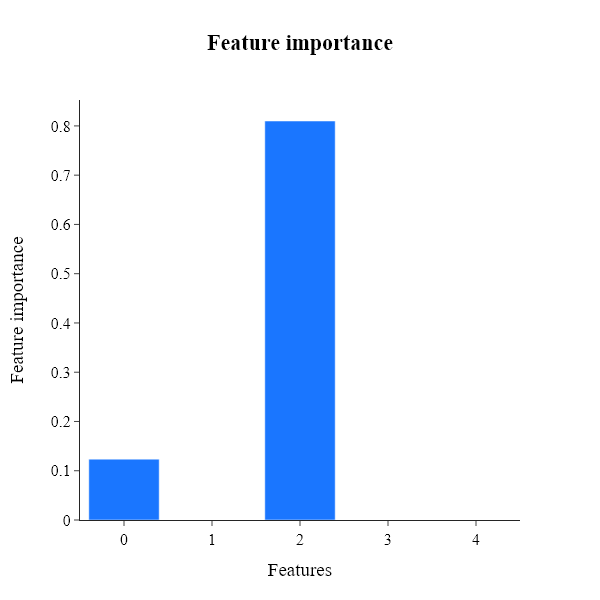

In [9]:
mi_scores = mutual_info.fit(X, y, discrete_features=False, target_discrete=False)
plot_feature_importances(feature_importances=mi_scores)

$\text{Porównanie ze sklearn.}$

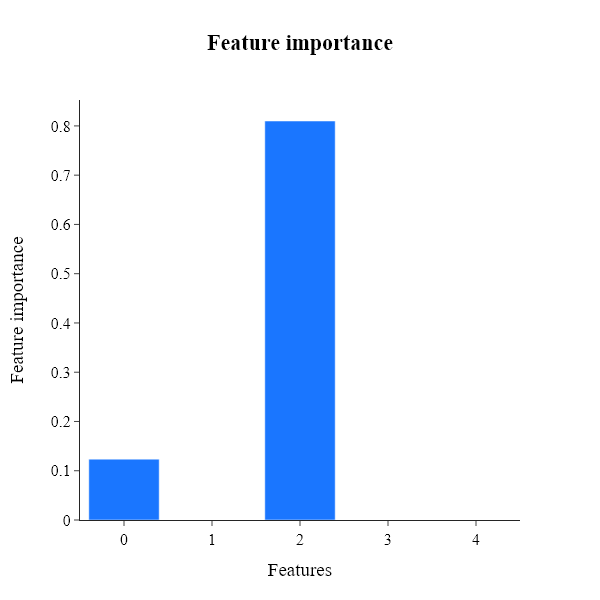

In [10]:
from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(X, y, discrete_features=False, random_state=17)
plot_feature_importances(feature_importances=mi)

### Zalety

$\text{Miara nieparametryczna, co oznacza, że nie zakłada ona określonego rozkładu danych.}$<p>
$\text{Bierze pod uwagę nie tylko rozkład prawdopodobieństwa, ale również liczebności analizowanych podgrup, przypisując wyższą wagę do tych bardziej licznych.}$

### Wady

$\text{Trudność w interpretacji/wytłumaczenia uzyskanych wartości.}$<p>
$\text{Brak jednej, poprawnej metody do ustalenia progu odcięcia przy selekcji zmiennych.}$

# Wrapper Methods

## Perturbacja

### Ogólny zarys

$\text{Sekwencyjna modyfikacja rozkładów zmiennych i obliczanie wynikającej z tego powodu straty.}$<p>
$\text{Istotność zmiennej } i \text{ w tym przypadku można interpretować jako: wielkość utraty mocy predykcyjnej modelu mierzona za pomocą wybranej metryki na skutek zmiany rozkładu zmiennej } i.$

### Schemat

$\text{1. Wytrenowanie modelu na wszystkich zmiennych.}$<p>
$\text{2. Obliczenie oryginalnego/pierwotnego wyniku.}$<p>
$\text{3. Otwieramy pętle } while(i<len(features))$<p>
$\qquad \text{I. Zmieniamy rozkład jednej zmiennej niezależnej (perturbacja).}$<p>
$\qquad \text{II. Sprawdzamy predykcje i obliczamy metrykę dla zmodyfikowanego zbioru.}$<p>
$\qquad \text{III. Zapisujemy różnicę jaka wynikła z przekształcenia danej zmiennej: } original-modified.$<p>
$\text{4. Porównanie wyników między zmiennymi. Zmienna, której usunięcie skutkowało największą różnicą } original-modified \text{ jest najgorsza, ponieważ niewielka zmiana w jej wartościach spowodowała dużą utratę mocy predykcyjnej modelu.}$

In [11]:
class Perturabtion:
    """This class is used to perform perturbation method for feature selection. It is based on the idea of changing the distribution of one column and checking how it affects the model performance."""

    def __init__(self, algorithm: typing.Any, metric: str, n_repeats: int):
        """This method initializes the class.

        Args:
            algorithm (typing.Any): algorithm to be used for feature selection.
            metric (str): metric to be used for evaluation.
            n_repeats (int): number of repeats for perturbation.
        """
        self.algorithm = algorithm
        self.n_repeats = n_repeats
        metrics = {
            "accuracy": [lambda y, y_pred: accuracy_score(y, y_pred), "preds"],
            "roc_auc": [lambda y, y_pred: roc_auc_score(y, y_pred), "probs"],
            "neg_mse": [lambda y, y_pred: -mean_squared_error(y, y_pred), "preds"],
            "neg_rmse": [
                lambda y, y_pred: -mean_squared_error(y, y_pred) ** 0.5,
                "preds",
            ],
            "neg_mae": [lambda y, y_pred: -mean_absolute_error(y, y_pred), "preds"],
        }
        if metric not in metrics:
            raise ValueError("Unsupported metric: {}".format(metric))
        self.metric = metric
        self.eval_metric = metrics[metric][0]
        self.metric_type = metrics[metric][1]

    def check_X(
        self, X: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """Check if X is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            X: (Union[pd.DataFrame, pd.Series, np.ndarray]): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        if (
            not isinstance(X, pd.DataFrame)
            and not isinstance(X, pd.Series)
            and not isinstance(X, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of X. It should be pandas DataFrame, pandas Series, numpy array."
            )
        X = np.array(X)
        if X.ndim == 1:
            X = X[None, :]
        return X

    def check_y(
        self, y: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """Check if y is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            y: (Union[pd.DataFrame, pd.Series, np.ndarray]): target data.

        Returns:
            y: (np.ndarray): converted target data.
        """
        if (
            not isinstance(y, pd.DataFrame)
            and not isinstance(y, pd.Series)
            and not isinstance(y, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of y. It should be pandas DataFrame, pandas Series, numpy array."
            )
        y = np.array(y)
        if y.ndim != 1:
            y = y.squeeze()
        return y

    def check_for_object_columns(self, X: np.ndarray) -> np.ndarray:
        """Check if X contains object columns and convert it to numeric data.

        Args:
            X: (np.ndarray): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        X = pd.DataFrame(X)
        if X.select_dtypes(include=np.number).shape[1] != X.shape[1]:
            raise TypeError(
                "Your data contains object or string columns. Numeric data is obligated."
            )
        return np.array(X)

    def fit(
        self,
        X: typing.Union[pd.DataFrame, pd.Series, np.ndarray],
        y: typing.Union[pd.DataFrame, pd.Series, np.ndarray],
        X_valid: typing.Union[pd.DataFrame, pd.Series, np.ndarray] = None,
        y_valid: typing.Union[pd.DataFrame, pd.Series, np.ndarray] = None,
        verbose: bool = False,
    ):
        """Fit the model and calculate feature importances.

        Args:
            X: (Union[pd.DataFrame, pd.Series, np.ndarray]): input data.
            y: (Union[pd.DataFrame, pd.Series, np.ndarray]): target data.
            X_valid: (Union[pd.DataFrame, pd.Series, np.ndarray]): validation input data.
            y_valid: (Union[pd.DataFrame, pd.Series, np.ndarray]): validation target data.
            verbose: (bool): whether to print fitting process.
        """
        X = self.check_X(X)
        X = self.check_for_object_columns(X)
        y = self.check_y(y)
        if X_valid is not None:
            X_train = np.copy(X)
            y_train = np.copy(y)
            X_valid = self.check_X(X_valid)
            X_valid = self.check_for_object_columns(X_valid)
            y_valid = self.check_y(y_valid)
        else:
            X_train, X_valid, y_train, y_valid = train_test_split(
                X, y, test_size=0.2, random_state=17
            )
        self.unscaled_feature_importances_, self.feature_importances_, self.ranking_ = (
            self.perform_perturbation(X_train, y_train, X_valid, y_valid, verbose)
        )

    def perform_perturbation(
        self,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_valid: np.ndarray,
        y_valid: np.ndarray,
        verbose: bool = False,
    ) -> typing.Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Perform perturbation method for feature selection.

        Args:
            X_train: (np.ndarray): training input data.
            y_train: (np.ndarray): training target data.
            X_valid: (np.ndarray): validation input data.
            y_valid: (np.ndarray): validation target data.
            verbose: (bool): whether to print fitting process.

        Returns:
            unscaled_feature_importances_: (np.ndarray): unscaled feature importances.
            feature_importances_: (np.ndarray): scaled feature importances.
            ranking_: (np.ndarray): ranking of features.
        """
        self.algorithm.fit(X_train, y_train)
        if self.metric_type == "preds":
            y_pred_original = self.algorithm.predict(X_valid)
        else:
            y_pred_original = self.algorithm.predict_proba(X_valid)[:, 1]
        score = self.eval_metric(y_valid, y_pred_original)
        if verbose == True:
            print(f"Original score: {round(score, 4)}")
        i = 0
        feature_importances = []
        while i < X_train.shape[-1]:
            X_valid_copy = X_valid.copy()
            inner_scores = []
            for j in range(self.n_repeats):
                # Change distribution of our column i with random values from - median to median of this column values
                perturbation = np.random.uniform(
                    low=-np.median(X_valid_copy[:, i]),
                    high=np.median(X_valid_copy[:, i]),
                    size=X_valid_copy.shape[:-1],
                )
                X_valid_copy[:, i] = X_valid_copy[:, i] + perturbation
                if self.metric_type == "preds":
                    y_pred_inner = self.algorithm.predict(X_valid_copy)
                else:
                    y_pred_inner = self.algorithm.predict_proba(X_valid_copy)[:, 1]
                inner_scores.append(self.eval_metric(y_valid, y_pred_inner))
            feature_importances.append(score - np.mean(inner_scores))
            if verbose == True:
                print(f"Feature importance for {i}: {round(feature_importances[i], 4)}")
            i = i + 1
        unscaled_feature_importances_ = np.array(feature_importances)
        feature_importances_ = np.squeeze(
            MinMaxScaler()
            .fit_transform(np.array(feature_importances).reshape(-1, 1))
            .reshape(1, -1)
        )
        ranking_ = rankdata(1 - feature_importances_, method="dense")
        return unscaled_feature_importances_, feature_importances_, ranking_

perturbation = Perturabtion(algorithm=model, metric="neg_mse", n_repeats=5)

Feature ranking: [2 3 1 3 3]


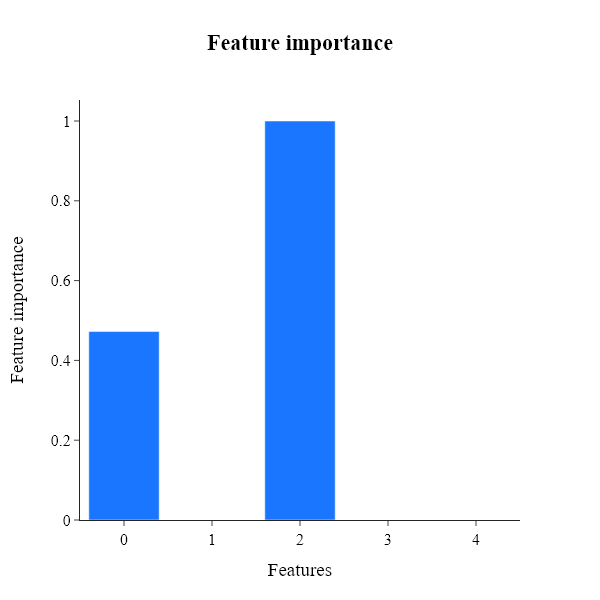

In [12]:
perturbation.fit(X, y, verbose=False)
print("Feature ranking: {}".format(perturbation.ranking_))
plot_feature_importances(feature_importances=perturbation.feature_importances_)

### Zalety

$\text{Prosty w implementacji oraz interpretacji otrzymanych wyników.}$

### Wady

$\text{Aplikacja tylko dla prostych zbiorów danych, gdzie zmienne niezależne są ciągłe lub quasi-ciągłe.}$<p>
$\text{Wielokrotne trenowanie przez co proces jest czasochłonny.}$

## Leave One Feature Out

### Ogólny zarys

$\text{Sekwencyjne usuwanie zmiennych z modelu i obliczanie wynikającej z tego powodu straty.}$<p>
$\text{Istotność zmiennej } i \text{ w tym przypadku można interpretować jako: wielkość utraty mocy predykcyjnej modelu mierzona za pomocą wybranej metryki na skutek usunięcia zmiennej } i.$

### Schemat

$\text{1. Wytrenowanie algorytmu na zbiorze treningowym zawierającym wszystkie zmienne i ewaluacja na zbiorze walidacyjnym (original).}$<p>
$\text{2. Otwarcie pętli, w której iteracyjnie usuwana jest jedna zmienna z oryginalnego zbioru danych.}$<p>
$\qquad \text{I. Wytrenowanie algorytmu na zmodyfikowanym zbiorze.}$<p>
$\qquad \text{II. Ewaluacja na zbiorze walidacyjnym (modified).}$<p>
$\qquad \text{III. Zapisujemy różnicę jaka wynikła z przekształceń danej zmiennej.}$<p>
$\text{3. Porównanie wyników między zmiennymi. Zmienna, której usunięcie skutkowało najmniejszą różnicą } original-modified \text{ jest najgorsza.}$

In [13]:
class LeaveOneFeatureOut:
    """This class is used to perform Leave One Feature Out method for feature selection. It is based on the idea of checking how the model performance changes when we remove one of the features."""

    def __init__(self, algorithm: typing.Any, metric: str):
        """This method initializes the class.

        Args:
            algorithm (typing.Any): algorithm that will be used for feature selection.
            metric (str): metric that will be used for evaluation.
        """
        self.algorithm = algorithm
        metrics = {
            "accuracy": [lambda y, y_pred: accuracy_score(y, y_pred), "preds"],
            "roc_auc": [lambda y, y_pred: roc_auc_score(y, y_pred), "probs"],
            "neg_mse": [lambda y, y_pred: -mean_squared_error(y, y_pred), "preds"],
            "neg_rmse": [
                lambda y, y_pred: -mean_squared_error(y, y_pred) ** 0.5,
                "preds",
            ],
            "neg_mae": [lambda y, y_pred: -mean_absolute_error(y, y_pred), "preds"],
        }
        if metric not in metrics:
            raise ValueError("Unsupported metric: {}".format(metric))
        self.metric = metric
        self.eval_metric = metrics[metric][0]
        self.metric_type = metrics[metric][1]

    def check_X(
        self, X: typing.Union[pd.DataFrame, pd.Series, np.ndarray, typing.List]
    ) -> np.ndarray:
        """Check if X is pandas DataFrame, pandas Series, numpy array or List and convert it to numpy array.

        Args:
            X: (Union[pd.DataFrame, pd.Series, np.ndarray, List]): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        if (
            not isinstance(X, pd.DataFrame)
            and not isinstance(X, pd.Series)
            and not isinstance(X, np.ndarray)
            and not isinstance(X, typing.List)
        ):
            raise TypeError(
                "Wrong type of X. It should be pandas DataFrame, pandas Series, numpy array or List."
            )
        X = np.array(X)
        if X.ndim == 1:
            X = X[None, :]
        return X

    def check_for_object_columns(self, X: np.ndarray) -> np.ndarray:
        """Check if X contains object columns and convert it to numeric data.

        Args:
            X: (np.ndarray): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        X = pd.DataFrame(X)
        if X.select_dtypes(include=np.number).shape[1] != X.shape[1]:
            raise TypeError(
                "Your data contains object or string columns. Numeric data is obligated."
            )
        return np.array(X)

    def check_y(
        self, y: typing.Union[pd.DataFrame, pd.Series, np.ndarray, typing.List]
    ) -> np.ndarray:
        """Check if y is pandas DataFrame, pandas Series, numpy array or List and convert it to numpy array.

        Args:
            y: (Union[pd.DataFrame, pd.Series, np.ndarray, List]): target data.

        Returns:
            y: (np.ndarray): converted target data.
        """
        if (
            not isinstance(y, pd.DataFrame)
            and not isinstance(y, pd.Series)
            and not isinstance(y, np.ndarray)
            and not isinstance(y, typing.List)
        ):
            raise TypeError(
                "Wrong type of X. It should be pandas DataFrame, pandas Series, numpy array or List."
            )
        y = np.array(y)
        if y.ndim == 2:
            y = y.squeeze()
        return y

    def fit(
        self,
        X: typing.Union[pd.DataFrame, pd.Series, np.ndarray, typing.List],
        y: typing.Union[pd.DataFrame, pd.Series, np.ndarray, typing.List],
        X_valid: typing.Union[pd.DataFrame, pd.Series, np.ndarray, typing.List] = None,
        y_valid: typing.Union[pd.DataFrame, pd.Series, np.ndarray, typing.List] = None,
        verbose: bool = False,
    ):
        """This method is used to perform Leave One Feature Out method for feature selection.

        Args:
            X: (Union[pd.DataFrame, pd.Series, np.ndarray, List]): input data.
            y: (Union[pd.DataFrame, pd.Series, np.ndarray, List]): target data.
            X_valid: (Union[pd.DataFrame, pd.Series, np.ndarray, List]): validation input data.
            y_valid: (Union[pd.DataFrame, pd.Series, np.ndarray, List]): validation target data.
            verbose: (bool): whether to print fitting process.
        """
        X = self.check_X(X)
        X = self.check_for_object_columns(X)
        y = self.check_y(y)
        if X_valid is not None:
            X_train = np.copy(X)
            y_train = np.copy(y)
            X_valid = self.check_X(X_valid)
            X_valid = self.check_for_object_columns(X_valid)
            y_valid = self.check_y(y_valid)
        else:
            X_train, X_valid, y_train, y_valid = train_test_split(
                X, y, test_size=0.2, random_state=17
            )
        self.unscaled_feature_importances_, self.feature_importances_, self.ranking_ = (
            self.perform_lofo(X_train, y_train, X_valid, y_valid, verbose)
        )

    def perform_lofo(
        self,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_valid: np.ndarray,
        y_valid: np.ndarray,
        verbose: bool = False,
    ) -> typing.Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """This method is used to perform Leave One Feature Out method for feature selection.

        Args:
            X_train: (np.ndarray): input data.
            y_train: (np.ndarray): target data.
            X_valid: (np.ndarray): validation input data.
            y_valid: (np.ndarray): validation target data.
            verbose: (bool): whether to print fitting process.

        Returns:
            unscaled_feature_importances_: (np.ndarray): unscaled feature importances.
            feature_importances_: (np.ndarray): scaled feature importances.
            ranking_: (np.ndarray): ranking of features.
        """
        self.algorithm.fit(X_train, y_train)
        if self.metric_type == "preds":
            y_pred_original = self.algorithm.predict(X_valid)
        else:
            y_pred_original = self.algorithm.predict_proba(X_valid)[:, 1]
        score = self.eval_metric(y_valid, y_pred_original)
        if verbose == True:
            print(f"Original score: {round(score, 4)}")
        i = 0
        feature_importances = []
        while i < X_train.shape[-1]:
            X_train_copy = X_train.copy()
            X_valid_copy = X_valid.copy()
            # Drop one of the columns
            X_train_copy = np.delete(X_train_copy, i, axis=1)
            X_valid_copy = np.delete(X_valid_copy, i, axis=1)
            self.algorithm.fit(X_train_copy, y_train)
            if self.metric_type == "preds":
                y_pred_inner = self.algorithm.predict(X_valid_copy)
            else:
                y_pred_inner = self.algorithm.predict_proba(X_valid_copy)[:, 1]
            feature_importances.append(score - self.eval_metric(y_valid, y_pred_inner))
            if verbose == True:
                print(f"Feature importance for {i}: {round(feature_importances[i], 4)}")
            i = i + 1
        unscaled_feature_importances_ = np.array(feature_importances)
        feature_importances_ = np.squeeze(
            MinMaxScaler()
            .fit_transform(np.array(feature_importances).reshape(-1, 1))
            .reshape(1, -1)
        )
        ranking_ = rankdata(1 - feature_importances_, method="dense")
        return unscaled_feature_importances_, feature_importances_, ranking_

lofo = LeaveOneFeatureOut(algorithm=model, metric="neg_mse")

Feature ranking: [2 3 1 3 3]


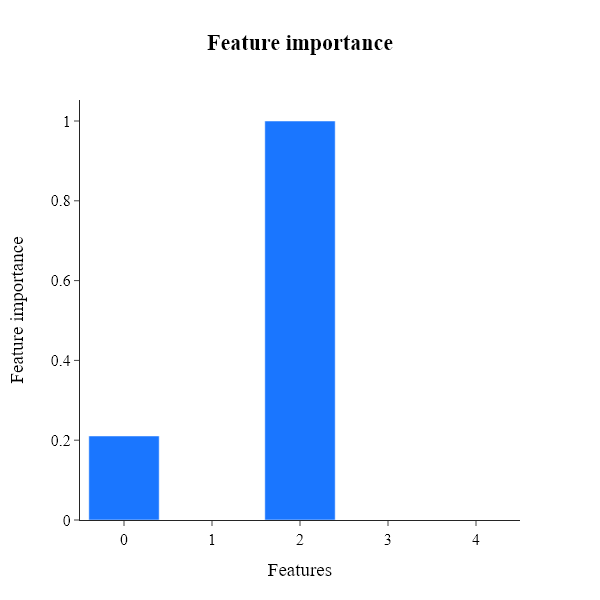

In [14]:
lofo.fit(X, y, verbose=False)
print("Feature ranking: {}".format(lofo.ranking_))
plot_feature_importances(feature_importances=lofo.feature_importances_)

### Zalety

$\text{Prosty w implementacji oraz interpretacji otrzymanych wyników.}$

### Wady

$\text{Pomijanie występującej między zmiennymi niezależnymi interakcji.}$<p>
$\text{Wielokrotne trenowanie przez co proces jest czasochłonny.}$

## Forward Feature Selection

### Ogólny zarys

$\text{Sekwencyjne dodawanie zmiennych do modelu i obliczanie wynikającej z tego powodu zmiany metryki ewaluacyjnej.}$

### Schemat

$\text{1. Otwieramy pętle } while(i<len(features))$<p>
$\qquad \text{I. Wytrenowanie modelu na zbiorze treningowym zawierającym zmienną } i$<p>
$\qquad \text{II. Ewaluacja na zbiorze walidacyjnym.}$<p>
$\qquad \text{III. Jeżeli wynik był najlepszy to zapisujemy zmienną w liście } best\_features.$<p>
$\text{2. Wyznaczamy zbiór } rest\_features \text{ gdzie } rest\_features = features - best\_features.$<p>
$\text{3. Otwieramy pętle } for \ i \ in \ rest\_features:$<p>
$\qquad \text{I. Dodajemy do aktualnego zbioru } best\_features \text{ zmienną } i \text{ a następnie trenujemy model dla tego zbioru.}$<p>
$\qquad \text{II. Ewaluacja na zbiorze walidacyjnym.}$<p>
$\qquad \text{III. Jeżeli wynik był najlepszy to zapisujemy zmienną w liście } best\_features \text{ oraz usuwamy z listy } rest\_features \text{ i startujemy pętlę od nowa.}$<p>
$\text{4. Zbiór } best\_features \text{ zawiera najlepsze zmienne.}$<p>

$\text{UWAGA w punkcie III pętli for, wykonujemy zabieg startowania pętli od nowa, ponieważ możliwa jest interakcja pomiędzy zmiennymi.}$<p>
$\text{Przykładowo jeśli zachodzi interakcja między zmiennymi } i \text{ oraz } j \text{ to dodanie zmiennej } i \text{ może spowodować, że zmienna } j \text{ stanie się istotna.}$

In [15]:
class ForwardFeatureSelection:
    """Forward feature selection algorithm."""

    def __init__(
        self,
        algorithm: typing.Any,
        metric: str,
        cv: typing.Any = KFold(n_splits=5, shuffle=True),
    ):
        """This method initializes the class.

        Args:
            algorithm (typing.Any): algorithm that will be used for feature selection.
            metric (str): metric that will be used for evaluation.
            cv (typing.Any): cross-validation strategy that will be used for evaluation.
        """
        self.algorithm = algorithm
        metrics = {
            "accuracy": [lambda y, y_pred: accuracy_score(y, y_pred), "preds"],
            "roc_auc": [lambda y, y_pred: roc_auc_score(y, y_pred), "probs"],
            "neg_mse": [lambda y, y_pred: -mean_squared_error(y, y_pred), "preds"],
            "neg_rmse": [
                lambda y, y_pred: -mean_squared_error(y, y_pred) ** 0.5,
                "preds",
            ],
            "neg_mae": [lambda y, y_pred: -mean_absolute_error(y, y_pred), "preds"],
        }
        if metric not in metrics:
            raise ValueError("Unsupported metric: {}".format(metric))
        self.metric = metric
        self.eval_metric = metrics[metric][0]
        self.metric_type = metrics[metric][1]
        self.cv = cv

    def check_X(
        self, X: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """Check if X is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            X: (Union[pd.DataFrame, pd.Series, np.ndarray]): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        if (
            not isinstance(X, pd.DataFrame)
            and not isinstance(X, pd.Series)
            and not isinstance(X, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of X. It should be pandas DataFrame, pandas Series, numpy array."
            )
        X = np.array(X)
        if X.ndim == 1:
            X = X[None, :]
        return X

    def check_y(
        self, y: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """Check if y is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            y: (Union[pd.DataFrame, pd.Series, np.ndarray]): target data.

        Returns:
            y: (np.ndarray): converted target data.
        """
        if (
            not isinstance(y, pd.DataFrame)
            and not isinstance(y, pd.Series)
            and not isinstance(y, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of y. It should be pandas DataFrame, pandas Series, numpy array."
            )
        y = np.array(y)
        if y.ndim != 1:
            y = y.squeeze()
        return y

    def check_for_object_columns(self, X: np.ndarray) -> np.ndarray:
        """Check if X contains object columns and convert it to numeric data.

        Args:
            X: (np.ndarray): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        X = pd.DataFrame(X)
        if X.select_dtypes(include=np.number).shape[1] != X.shape[1]:
            raise TypeError(
                "Your data contains object or string columns. Numeric data is obligated."
            )
        return np.array(X)

    def fit(
        self,
        X: typing.Union[pd.DataFrame, pd.Series, np.ndarray],
        y: typing.Union[pd.DataFrame, pd.Series, np.ndarray],
        X_valid: typing.Union[pd.DataFrame, pd.Series, np.ndarray] = None,
        y_valid: typing.Union[pd.DataFrame, pd.Series, np.ndarray] = None,
        verbose: bool = False,
    ):
        """This method fits the model.

        Args:
            X: (Union[pd.DataFrame, pd.Series, np.ndarray]): input data.
            y: (Union[pd.DataFrame, pd.Series, np.ndarray]): target data.
            X_valid: (Union[pd.DataFrame, pd.Series, np.ndarray]): validation input data.
            y_valid: (Union[pd.DataFrame, pd.Series, np.ndarray]): validation target data.
            verbose: (bool): whether to print fitting process.
        """
        X = self.check_X(X)
        X = self.check_for_object_columns(X)
        y = self.check_y(y)
        if X_valid is not None:
            X_train = np.copy(X)
            y_train = np.copy(y)
            X_valid = self.check_X(X_valid)
            X_valid = self.check_for_object_columns(X_valid)
            y_valid = self.check_y(y_valid)
            self.indices_of_best_, self.support_ = self.perform_ffs_no_cv(
                X_train, y_train, X_valid, y_valid, verbose
            )
        else:
            self.indices_of_best_, self.support_ = self.perform_ffs_cv(X, y, verbose)

    def perform_ffs_no_cv(
        self,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_valid: np.ndarray,
        y_valid: np.ndarray,
        verbose: bool,
    ) -> typing.Tuple[np.ndarray, np.ndarray]:
        """This method performs forward feature selection without cross-validation.

        Args:
            X_train: (np.ndarray): training input data.
            y_train: (np.ndarray): training target data.
            X_valid: (np.ndarray): validation input data.
            y_valid: (np.ndarray): validation target data.
            verbose: (bool): whether to print fitting process.

        Returns:
            best_features: (np.ndarray): best features.
            support_: (np.ndarray): boolean mask of the best features.
        """
        best_init_score = -np.inf
        i = 0
        while i < X_train.shape[-1]:
            self.algorithm.fit(X_train[:, i].reshape(-1, 1), y_train)
            if self.metric_type == "preds":
                y_pred_original = self.algorithm.predict(X_valid[:, i].reshape(-1, 1))
            else:
                y_pred_original = self.algorithm.predict_proba(
                    X_valid[:, i].reshape(-1, 1)
                )[:, 1]
            score = self.eval_metric(y_valid, y_pred_original)
            if best_init_score < score:
                best_init_score = score
                best_features = [i]
            i = i + 1
        best_score = best_init_score
        rest_features = np.setdiff1d(
            [i for i in range(X_train.shape[1])], best_features
        )
        while True:
            restart = False
            for i in rest_features:
                if verbose == True:
                    print(
                        "We check how the current set: {} will manage with an additional variable: {}".format(
                            best_features, i
                        )
                    )
                X_train_copy = X_train[:, best_features + [i]]
                X_valid_copy = X_valid[:, best_features + [i]]
                self.algorithm.fit(X_train_copy, y_train)
                if self.metric_type == "preds":
                    y_pred_inner = self.algorithm.predict(X_valid_copy)
                else:
                    y_pred_inner = self.algorithm.predict_proba(X_valid_copy)[:, 1]
                score = self.eval_metric(y_valid, y_pred_inner)
                if score > best_score:
                    if verbose == True:
                        print("Improved! Because {}>{}".format(score, best_score))
                    best_score = score
                    best_features.append(i)
                    rest_features = np.setdiff1d(
                        [i for i in range(X_train.shape[-1])], best_features
                    )
                    restart = True
                    break
            if restart == False:
                break
        support_ = np.array(
            [True if i in best_features else False for i in range(0, X_train.shape[1])]
        ).astype(bool)
        return best_features, support_

    def perform_ffs_cv(
        self, X: np.ndarray, y: np.ndarray, verbose: bool
    ) -> typing.Tuple[np.ndarray, np.ndarray]:
        """This method performs forward feature selection with cross-validation.

        Args:
            X: (np.ndarray): input data.
            y: (np.ndarray): target data.
            verbose: (bool): whether to print fitting process.

        Returns:
            best_features: (np.ndarray): best features.
            support_: (np.ndarray): boolean mask of the best features.
        """
        best_init_score = -np.inf
        i = 0
        while i < X.shape[-1]:
            score = self.perform_cv(X[:, i].reshape(-1, 1), y)
            if best_init_score < score:
                best_init_score = score
                best_features = [i]
            i = i + 1
        best_score = best_init_score
        rest_features = np.setdiff1d([i for i in range(X.shape[1])], best_features)
        while True:
            restart = False
            for i in rest_features:
                if verbose == True:
                    print(
                        "We check how the current set: {} will manage with an additional variable: {}".format(
                            best_features, i
                        )
                    )
                X_copy = X[:, best_features + [i]]
                score = self.perform_cv(X_copy, y)
                if score > best_score:
                    if verbose == True:
                        print("Improved! Because {}>{}".format(score, best_score))
                    best_score = score
                    best_features.append(i)
                    rest_features = np.setdiff1d(
                        [i for i in range(X.shape[-1])], best_features
                    )
                    restart = True
                    break
            if restart == False:
                break
        support_ = np.array(
            [True if i in best_features else False for i in range(0, X.shape[1])]
        ).astype(bool)
        return best_features, support_

    def perform_cv(self, X: np.ndarray, y: np.ndarray) -> float:
        """This method performs cross-validation.

        Args:
            X: (np.ndarray): input data.
            y: (np.ndarray): target data.

        Returns:
            float: cross-validation score.
        """
        scores = []
        for train_index, test_index in self.cv.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            self.algorithm.fit(X_train, y_train)
            if self.metric_type == "preds":
                y_pred = self.algorithm.predict(X_test)
            else:
                y_pred = self.algorithm.predict_proba(X_test)[:, 1]
            scores.append(self.eval_metric(y_test, y_pred))
        return np.mean(scores)

forward = ForwardFeatureSelection(algorithm=model, metric="neg_mse", cv=KFold(n_splits=5, shuffle=True))

In [16]:
forward.fit(X, y, verbose=False)
print("Indices of best features: {}".format(forward.indices_of_best_))
print("Support: {}".format(forward.support_))

Indices of best features: [2, 0]
Support: [ True False  True False False]


### Zalety

$\text{Eksploracja większej liczby kombinacji zmiennych względem Backward Feature Selection.}$

### Wady

$\text{Brak cofania, czyli nie możemy usunąć raz wybranej cechy, przez co niekoniecznie wybrane cechy będą najlepsze.}$<p>
$\text{Pomijanie występującej między zmiennymi niezależnymi interakcji.}$

## Backward Feature Selection

### Ogólny zarys

$\text{Sekwencyjne usuwanie zmiennych z modelu i obliczanie wynikającej z tego powodu zmiany metryki ewaluacyjnej.}$

### Schemat

$\text{1. Otwieramy pętle } while(len(features)>1)$<p>
$\qquad \text{I. Jeżeli istnieje już jakaś zmienna } worst \text{ to ją usuwamy z } features.$<p>
$\qquad \text{II. Otwieramy pętle } while(j<len(features))$<p>
$\qquad \qquad \text{a) Usuwamy zmienną } j \text{ ze zbioru danych i trenujemy model.}$<p>
$\qquad \qquad \text{b) Ewaluacja na zbiorze walidacyjnym.}$<p>
$\qquad \qquad \text{c) Jeżeli wynik był najlepszy to zapisujemy go jako } best\_inner \text{, a zmienną jako } worst \text{ (czyli najgorszą zmienną jest ta po której usunięciu i wytrenowaniu modelu generujemy najlepszy wynik).}$<p>
$\qquad \text{III. Jeżeli nasz wynik } best\_inner \text{ był wyższy od ogólnego } best\_score \text{, to aktualizujemy: } best\_score=best\_inner \text{ oraz listę z najlepszymi zmiennymi } best\_features=features-worst.$<p>
$\text{2. Zbiór z najlepszymi zmiennymi to ten znajdujący się w liście } best\_features.$

In [17]:
class BackwardFeatureSelection:
    """Backward feature selection algorithm."""

    def __init__(
        self,
        algorithm: typing.Any,
        metric: str,
        cv: typing.Any = KFold(n_splits=5, shuffle=True),
    ):
        """This method initializes the class.

        Args:
            algorithm (typing.Any): algorithm that will be used for feature selection.
            metric (str): metric that will be used for evaluation.
            cv (typing.Any): cross-validation strategy that will be used for evaluation.
        """
        self.algorithm = algorithm
        metrics = {
            "accuracy": [lambda y, y_pred: accuracy_score(y, y_pred), "preds"],
            "roc_auc": [lambda y, y_pred: roc_auc_score(y, y_pred), "probs"],
            "neg_mse": [lambda y, y_pred: -mean_squared_error(y, y_pred), "preds"],
            "neg_rmse": [
                lambda y, y_pred: -mean_squared_error(y, y_pred) ** 0.5,
                "preds",
            ],
            "neg_mae": [lambda y, y_pred: -mean_absolute_error(y, y_pred), "preds"],
        }
        if metric not in metrics:
            raise ValueError("Unsupported metric: {}".format(metric))
        self.metric = metric
        self.eval_metric = metrics[metric][0]
        self.metric_type = metrics[metric][1]
        self.cv = cv

    def check_X(
        self, X: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """Check if X is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            X: (Union[pd.DataFrame, pd.Series, np.ndarray]): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        if (
            not isinstance(X, pd.DataFrame)
            and not isinstance(X, pd.Series)
            and not isinstance(X, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of X. It should be pandas DataFrame, pandas Series, numpy array."
            )
        X = np.array(X)
        if X.ndim == 1:
            X = X[None, :]
        return X

    def check_y(
        self, y: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """Check if y is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            y: (Union[pd.DataFrame, pd.Series, np.ndarray]): target data.

        Returns:
            y: (np.ndarray): converted target data.
        """
        if (
            not isinstance(y, pd.DataFrame)
            and not isinstance(y, pd.Series)
            and not isinstance(y, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of y. It should be pandas DataFrame, pandas Series, numpy array."
            )
        y = np.array(y)
        if y.ndim != 1:
            y = y.squeeze()
        return y

    def check_for_object_columns(self, X: np.ndarray) -> np.ndarray:
        """Check if X contains object columns and convert it to numeric data.

        Args:
            X: (np.ndarray): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        X = pd.DataFrame(X)
        if X.select_dtypes(include=np.number).shape[1] != X.shape[1]:
            raise TypeError(
                "Your data contains object or string columns. Numeric data is obligated."
            )
        return np.array(X)

    def fit(
        self,
        X: typing.Union[pd.DataFrame, pd.Series, np.ndarray],
        y: typing.Union[pd.DataFrame, pd.Series, np.ndarray],
        X_valid: typing.Union[pd.DataFrame, pd.Series, np.ndarray] = None,
        y_valid: typing.Union[pd.DataFrame, pd.Series, np.ndarray] = None,
        verbose: bool = False,
    ):
        """This method fits the model.

        Args:
            X: (Union[pd.DataFrame, pd.Series, np.ndarray]): input data.
            y: (Union[pd.DataFrame, pd.Series, np.ndarray]): target data.
            X_valid: (Union[pd.DataFrame, pd.Series, np.ndarray]): validation input data.
            y_valid: (Union[pd.DataFrame, pd.Series, np.ndarray]): validation target data.
            verbose: (bool): whether to print fitting process.
        """
        X = self.check_X(X)
        X = self.check_for_object_columns(X)
        y = self.check_y(y)
        if X_valid is not None:
            X_train = np.copy(X)
            y_train = np.copy(y)
            X_valid = self.check_X(X_valid)
            X_valid = self.check_for_object_columns(X_valid)
            y_valid = self.check_y(y_valid)
            self.indices_of_best_, self.support_ = self.perform_bfs_no_cv(
                X_train, y_train, X_valid, y_valid, verbose
            )
        else:
            self.indices_of_best_, self.support_ = self.perform_bfs_cv(X, y, verbose)

    def perform_bfs_no_cv(
        self,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_valid: np.ndarray,
        y_valid: np.ndarray,
        verbose: bool,
    ) -> typing.Tuple[np.ndarray, np.ndarray]:
        """This method performs backward feature selection without cross-validation.

        Args:
            X_train: (np.ndarray): training input data.
            y_train: (np.ndarray): training target data.
            X_valid: (np.ndarray): validation input data.
            y_valid: (np.ndarray): validation target data.
            verbose: (bool): whether to print fitting process.

        Returns:
            best_features: (np.ndarray): best features.
            support_: (np.ndarray): boolean mask of the best features.
        """
        original_features = [i for i in range(X_train.shape[-1])]
        features = original_features.copy()
        best_score = -np.inf
        worst = None
        i = 0
        while i < len(features):
            if worst is not None:
                features.remove(original_features[worst])
            best_score_inner = -np.inf
            j = 0
            while j < len(features):
                X_train_copy = X_train[
                    :, np.setdiff1d(features, [original_features[j]])
                ]
                X_valid_copy = X_valid[
                    :, np.setdiff1d(features, [original_features[j]])
                ]
                self.algorithm.fit(X_train_copy, y_train)
                if self.metric_type == "preds":
                    y_pred_inner = self.algorithm.predict(X_valid_copy)
                else:
                    y_pred_inner = self.algorithm.predict_proba(X_valid_copy)[:, 1]
                score = self.eval_metric(y_valid, y_pred_inner)
                if score > best_score_inner:
                    best_score_inner = score
                    worst = features[j]
                j = j + 1
            if best_score_inner > best_score:
                if verbose == True:
                    print(
                        "After removing the worst feature: {}, score improved, because: {}>{}".format(
                            worst, best_score_inner, best_score
                        )
                    )
                best_score = best_score_inner
                best_features = np.setdiff1d(features, [worst])
            i = i + 1
        support_ = np.array(
            [True if i in best_features else False for i in range(0, X_train.shape[1])]
        ).astype(bool)
        return best_features, support_

    def perform_bfs_cv(
        self, X: np.ndarray, y: np.ndarray, verbose: bool
    ) -> typing.Tuple[np.ndarray, np.ndarray]:
        """This method performs forward feature selection with cross-validation.

        Args:
            X: (np.ndarray): input data.
            y: (np.ndarray): target data.
            verbose: (bool): whether to print fitting process.

        Returns:
            best_features: (np.ndarray): best features.
            support_: (np.ndarray): boolean mask of the best features.
        """
        original_features = [i for i in range(X.shape[-1])]
        features = original_features.copy()
        best_score = -np.inf
        worst = None
        while len(features) > 1:
            if worst is not None:
                features.remove(original_features[worst])
            best_score_inner = -np.inf
            j = 0
            while j < len(features):
                if len(features) > 1:
                    X_copy = X[:, np.setdiff1d(features, [original_features[j]])]
                else:
                    X_copy = X[:, [original_features[j]]]
                score = self.perform_cv(X_copy, y)
                if score > best_score_inner:
                    best_score_inner = score
                    worst = features[j]
                j = j + 1
            if best_score_inner > best_score:
                if verbose == True:
                    print(
                        "After removing the worst feature: {}, score improved, because: {}>{}".format(
                            worst, best_score_inner, best_score
                        )
                    )
                best_score = best_score_inner
                best_features = np.setdiff1d(features, [worst])
        support_ = np.array(
            [True if i in best_features else False for i in range(0, X.shape[1])]
        ).astype(bool)
        return best_features, support_

    def perform_cv(self, X: np.ndarray, y: np.ndarray) -> float:
        """This method performs cross-validation.

        Args:
            X: (np.ndarray): input data.
            y: (np.ndarray): target data.

        Returns:
            float: cross-validation score.
        """
        scores = []
        for train_index, test_index in self.cv.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            self.algorithm.fit(X_train, y_train)
            if self.metric_type == "preds":
                y_pred = self.algorithm.predict(X_test)
            else:
                y_pred = self.algorithm.predict_proba(X_test)[:, 1]
            scores.append(self.eval_metric(y_test, y_pred))
        return np.mean(scores)

backward = BackwardFeatureSelection(algorithm=model, metric="neg_mse", cv=KFold(n_splits=5, shuffle=True))

In [18]:
backward.fit(X, y, verbose=True)
print("Indices of best features: {}".format(backward.indices_of_best_))
print("Support: {}".format(backward.support_))

After removing the worst feature: 4, score improved, because: -1.9357876223808163e-30>-inf
After removing the worst feature: 1, score improved, because: -4.211279884076245e-31>-1.9357876223808163e-30
Indices of best features: [0 2]
Support: [ True False  True False False]


### Zalety

$\text{Bierze pod uwagę interakcje pomiędzy zmiennymi.}$

### Wady

$\text{Tendencja do wyboru większej liczby zmiennych względem Forward Feature Selection.}$<p>

## Recursive Feature Elimination

$\text{Metoda jest podobna do Backward Feature Selection, jednak w tym przypadku zmienna jest usuwana na podstawie feature importance.}$

In [19]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=model, step=1)
rfe.fit(X, y)
print("Indices of best features: {}".format([i for i in range(len(rfe.support_)) if rfe.support_[i] == True]))
print("Ranking: {}".format(rfe.ranking_))
print("Support: {}".format(rfe.support_))

Indices of best features: [0, 2]
Ranking: [1 2 1 4 3]
Support: [ True False  True False False]


$\text{W sklearn dostępne jest również rozszerzenie o walidację krzyżową: RFECV.}$

In [20]:
from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=model, step=1, cv=KFold(n_splits=5, shuffle=True), scoring="neg_mean_squared_error")
rfecv.fit(X, y)
print("Indices of best features: {}".format([i for i in range(len(rfecv.support_)) if rfecv.support_[i] == True]))
print("Ranking: {}".format(rfecv.ranking_))
print("Support: {}".format(rfecv.support_))

Indices of best features: [0, 1, 2]
Ranking: [1 1 1 3 2]
Support: [ True  True  True False False]


$\text{Poniżej implementacja RFECV z Mutual Information.}$

In [21]:
class RFECVMutualInformation(MutualInformation):
    """This class is a feature selection technique that uses Recursive Feature Elimination with Cross-Validation and Mutual Information."""

    def __init__(
        self,
        algorithm: typing.Any,
        metric: str,
        cv: KFold,
        discrete_features: typing.List[bool],
        target_discrete: bool,
    ):
        """This method initializes the class.

        Args:
            algorithm (typing.Any): algorithm that will be used for feature selection.
            metric (str): metric that will be used for evaluation.
            cv (KFold): cross-validation technique that will be used.
            discrete_features (typing.List[bool]): list of booleans that indicates whether the feature is discrete or not.
            target_discrete (bool): boolean that indicates whether the target is discrete or not.
        """
        self.algorithm = algorithm
        metrics = {
            "accuracy": [lambda y, y_pred: accuracy_score(y, y_pred), "preds"],
            "roc_auc": [lambda y, y_pred: roc_auc_score(y, y_pred), "probs"],
            "neg_mse": [lambda y, y_pred: -mean_squared_error(y, y_pred), "preds"],
            "neg_rmse": [
                lambda y, y_pred: -mean_squared_error(y, y_pred) ** 0.5,
                "preds",
            ],
            "neg_mae": [lambda y, y_pred: -mean_absolute_error(y, y_pred), "preds"],
        }
        if metric not in metrics:
            raise ValueError("Unsupported metric: {}".format(metric))
        self.metric = metric
        self.eval_metric = metrics[metric][0]
        self.metric_type = metrics[metric][1]
        self.cv = cv
        self.mutual_information = MutualInformation(n_neighbors=3, random_state=17)
        self.discrete_features_ = discrete_features
        self.discrete_target_ = target_discrete

    def check_X(
        self, X: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """Check if X is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            X: (Union[pd.DataFrame, pd.Series, np.ndarray]): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        if (
            not isinstance(X, pd.DataFrame)
            and not isinstance(X, pd.Series)
            and not isinstance(X, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of X. It should be pandas DataFrame, pandas Series, numpy array."
            )
        X = np.array(X)
        if X.ndim == 1:
            X = X[None, :]
        return X

    def check_y(
        self, y: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """Check if y is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            y: (Union[pd.DataFrame, pd.Series, np.ndarray]): target data.

        Returns:
            y: (np.ndarray): converted target data.
        """
        if (
            not isinstance(y, pd.DataFrame)
            and not isinstance(y, pd.Series)
            and not isinstance(y, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of y. It should be pandas DataFrame, pandas Series, numpy array."
            )
        y = np.array(y)
        if y.ndim != 1:
            y = y.squeeze()
        return y

    def check_for_object_columns(self, X: np.ndarray) -> np.ndarray:
        """Check if X contains object columns and convert it to numeric data.

        Args:
            X: (np.ndarray): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        X = pd.DataFrame(X)
        if X.select_dtypes(include=np.number).shape[1] != X.shape[1]:
            raise TypeError(
                "Your data contains object or string columns. Numeric data is obligated."
            )
        return np.array(X)

    def fit(
        self,
        X: typing.Union[pd.DataFrame, pd.Series, np.ndarray],
        y: typing.Union[pd.DataFrame, pd.Series, np.ndarray],
        verbose: bool = False,
    ) -> None:
        """Fit the Recursive Feature Elimination with Cross-Validation and Mutual Information to the data.

        Args:
            X (Union[pd.DataFrame, pd.Series, np.ndarray]): input data.
            y (Union[pd.DataFrame, pd.Series, np.ndarray]): target data.
            verbose (bool): boolean that indicates whether the information about the process will be printed out.
        """
        X = self.check_X(X)
        X = self.check_for_object_columns(X)
        y = self.check_y(y)
        self.mi_ = list(
            self.mutual_information.fit(
                X,
                y,
                discrete_features=self.discrete_features_,
                target_discrete=self.discrete_target_,
            )
        )
        self.indices_of_best_, self.support_ = self.perform_rfecv(X, y, verbose)

    def perform_rfecv(
        self, X: np.ndarray, y: np.ndarray, verbose: bool
    ) -> typing.Tuple[np.ndarray, np.ndarray]:
        """Perform the Recursive Feature Elimination with Cross-Validation.

        Args:
            X (np.ndarray): input data.
            y (np.ndarray): target data.
            verbose (bool): boolean that indicates whether the information about the process will be printed out.

        Returns:
            best_features (np.ndarray): indices of the best features.
            support_ (np.ndarray): boolean mask of the best features.
        """
        original_features = [i for i in range(X.shape[-1])]
        features = original_features.copy()
        best_score = -np.inf
        worst = None
        while len(features) > 1:
            if worst is not None:
                features.remove(original_features[worst])
            X_copy = X[:, features]
            score = self.perform_cv(X_copy, y)
            if score > best_score:
                if verbose == True:
                    print(
                        "After removing the worst feature: {}, score improved, because: {}>{}".format(
                            worst, score, best_score
                        )
                    )
                best_score = score
                best_features = np.setdiff1d(features, [worst])
            worst = features[np.argmin([self.mi_[i] for i in features])]
        support_ = np.array(
            [True if i in best_features else False for i in range(0, X.shape[1])]
        ).astype(bool)
        return best_features, support_

    def perform_cv(self, X: np.ndarray, y: np.ndarray) -> float:
        """This method performs cross-validation.

        Args:
            X: (np.ndarray): input data.
            y: (np.ndarray): target data.

        Returns:
            float: cross-validation score.
        """
        scores = []
        for train_index, test_index in self.cv.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            self.algorithm.fit(X_train, y_train)
            if self.metric_type == "preds":
                y_pred = self.algorithm.predict(X_test)
            else:
                y_pred = self.algorithm.predict_proba(X_test)[:, 1]
            scores.append(self.eval_metric(y_test, y_pred))
        return np.mean(scores)

rfecv_mi = RFECVMutualInformation(algorithm=model, metric="neg_mse", discrete_features=False, target_discrete=False, cv=KFold(n_splits=5, shuffle=True))

In [22]:
rfecv_mi.fit(X, y, verbose=False)
print("Indices of best features: {}".format(rfecv_mi.indices_of_best_))
print("Support: {}".format(rfecv_mi.support_))

Indices of best features: [0 2]
Support: [ True False  True False False]


## Exhaustive Feature Selection

### Ogólny zarys

$\text{Eksploracja wszystkich możliwych kombinacji zmiennych.}$

### Schemat

$\text{1. Utworzenie zbioru ze wszystkimi możliwymi kombinacjami zmiennych: } combinations.$<p>
$\text{2. Otwieramy pętle } for \ subset \ in \ combinations:$<p>
$\qquad \text{I. Trenujemy model na zbiorze treningowym zawierającym zmienne z } subset.$<p>
$\qquad \text{II. Ewaluacja na zbiorze walidacyjnym.}$<p>
$\qquad \text{III. Jeżeli wynik był najlepszy to zapisujemy wynik jako } best\_score \text{ a zbiór zmiennych: } best\_features$<p>
$\text{3. Zbiór } best\_features \text{ zawiera najlepsze zmienne.}$

In [23]:
class ExhaustiveFeatureSelection:
    """A class to perform exhaustive feature selection."""

    def __init__(
        self,
        algorithm: typing.Any,
        metric: str,
        cv: typing.Any = KFold(n_splits=5, shuffle=True),
    ):
        """This method initializes the class.

        Args:
            algorithm (typing.Any): algorithm that will be used for feature selection.
            metric (str): metric that will be used for evaluation.
            cv (typing.Any): cross-validation strategy that will be used for evaluation.
        """
        self.algorithm = algorithm
        metrics = {
            "accuracy": [lambda y, y_pred: accuracy_score(y, y_pred), "preds"],
            "roc_auc": [lambda y, y_pred: roc_auc_score(y, y_pred), "probs"],
            "neg_mse": [lambda y, y_pred: -mean_squared_error(y, y_pred), "preds"],
            "neg_rmse": [
                lambda y, y_pred: -mean_squared_error(y, y_pred) ** 0.5,
                "preds",
            ],
            "neg_mae": [lambda y, y_pred: -mean_absolute_error(y, y_pred), "preds"],
        }
        if metric not in metrics:
            raise ValueError("Unsupported metric: {}".format(metric))
        self.metric = metric
        self.eval_metric = metrics[metric][0]
        self.metric_type = metrics[metric][1]
        self.cv = cv

    def check_X(
        self, X: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """Check if X is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            X: (Union[pd.DataFrame, pd.Series, np.ndarray]): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        if (
            not isinstance(X, pd.DataFrame)
            and not isinstance(X, pd.Series)
            and not isinstance(X, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of X. It should be pandas DataFrame, pandas Series, numpy array."
            )
        X = np.array(X)
        if X.ndim == 1:
            X = X[None, :]
        return X

    def check_y(
        self, y: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """Check if y is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            y: (Union[pd.DataFrame, pd.Series, np.ndarray]): target data.

        Returns:
            y: (np.ndarray): converted target data.
        """
        if (
            not isinstance(y, pd.DataFrame)
            and not isinstance(y, pd.Series)
            and not isinstance(y, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of y. It should be pandas DataFrame, pandas Series, numpy array."
            )
        y = np.array(y)
        if y.ndim != 1:
            y = y.squeeze()
        return y

    def check_for_object_columns(self, X: np.ndarray) -> np.ndarray:
        """Check if X contains object columns and convert it to numeric data.

        Args:
            X: (np.ndarray): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        X = pd.DataFrame(X)
        if X.select_dtypes(include=np.number).shape[1] != X.shape[1]:
            raise TypeError(
                "Your data contains object or string columns. Numeric data is obligated."
            )
        return np.array(X)

    def fit(
        self,
        X: typing.Union[pd.DataFrame, pd.Series, np.ndarray],
        y: typing.Union[pd.DataFrame, pd.Series, np.ndarray],
        X_valid: typing.Union[pd.DataFrame, pd.Series, np.ndarray] = None,
        y_valid: typing.Union[pd.DataFrame, pd.Series, np.ndarray] = None,
        verbose: bool = False,
    ) -> None:
        """This method fits the model.

        Args:
            X: (Union[pd.DataFrame, pd.Series, np.ndarray]): input data.
            y: (Union[pd.DataFrame, pd.Series, np.ndarray]): target data.
            X_valid: (Union[pd.DataFrame, pd.Series, np.ndarray]): validation input data.
            y_valid: (Union[pd.DataFrame, pd.Series, np.ndarray]): validation target data.
            verbose: (bool): whether to print fitting process.
        """
        X = self.check_X(X)
        X = self.check_for_object_columns(X)
        y = self.check_y(y)
        if X_valid is not None:
            X_train = np.copy(X)
            y_train = np.copy(y)
            X_valid = self.check_X(X_valid)
            X_valid = self.check_for_object_columns(X_valid)
            y_valid = self.check_y(y_valid)
            self.indices_of_best_, self.support_ = self.perform_exhaustive_no_cv(
                X_train, y_train, X_valid, y_valid, verbose
            )
        else:
            self.indices_of_best_, self.support_ = self.perform_exhaustive_cv(
                X, y, verbose
            )

    def perform_exhaustive_no_cv(
        self,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_valid: np.ndarray,
        y_valid: np.ndarray,
        verbose: bool,
    ) -> typing.Tuple[np.ndarray, np.ndarray]:
        """This method performs exhaustive feature selection without cross-validation.

        Args:
            X_train: (np.ndarray): input data.
            y_train: (np.ndarray): target data.
            X_valid: (np.ndarray): validation input data.
            y_valid: (np.ndarray): validation target data.
            verbose: (bool): whether to print fitting process.

        Returns:
            best_features: (list): list of best features.
            support_: (np.ndarray): boolean mask of the best features.
        """
        combinations = list(
            list(comb([i for i in range(X_train.shape[-1])], i))
            for i in range(1, X_train.shape[-1] + 1)
        )
        combinations = [item for sublist in combinations for item in sublist]
        best_score = -np.inf
        for combination in combinations:
            X_train_subset = X_train[:, combination]
            X_valid_subset = X_valid[:, combination]
            self.algorithm.fit(X_train_subset, y_train)
            if self.metric_type == "preds":
                y_pred_inner = self.algorithm.predict(X_valid_subset)
            else:
                y_pred_inner = self.algorithm.predict_proba(X_valid_subset)[:, 1]
            score = self.eval_metric(y_valid, y_pred_inner)
            if score > best_score:
                if verbose == True:
                    print(
                        "Current best combination: {}, beacuse score improved: {}>{}".format(
                            list(combination), score, best_score
                        )
                    )
                best_score = score
                best_features = list(combination)
        support_ = np.array(
            [True if i in best_features else False for i in range(0, X_train.shape[1])]
        ).astype(bool)
        return best_features, support_

    def perform_exhaustive_cv(
        self, X: np.ndarray, y: np.ndarray, verbose: bool
    ) -> typing.Tuple[np.ndarray, np.ndarray]:
        """This method performs exhaustive feature selection with cross-validation.

        Args:
            X: (np.ndarray): input data.
            y: (np.ndarray): target data.
            verbose: (bool): whether to print fitting process.

        Returns:
            best_features: (list): list of best features.
            support_: (np.ndarray): boolean mask of the best features.
        """
        combinations = list(
            list(comb([i for i in range(X.shape[-1])], i))
            for i in range(1, X.shape[-1] + 1)
        )
        combinations = [item for sublist in combinations for item in sublist]
        best_score = -np.inf
        for combination in combinations:
            X_subset = X[:, combination]
            score = self.perform_cv(X_subset, y)
            if score > best_score:
                if verbose == True:
                    print(
                        "Current best combination: {}, beacuse score improved: {}>{}".format(
                            list(combination), score, best_score
                        )
                    )
                best_score = score
                best_features = list(combination)
        support_ = np.array(
            [True if i in best_features else False for i in range(0, X.shape[1])]
        ).astype(bool)
        return best_features, support_

    def perform_cv(self, X: np.ndarray, y: np.ndarray) -> float:
        """This method performs cross-validation.

        Args:
            X: (np.ndarray): input data.
            y: (np.ndarray): target data.

        Returns:
            float: cross-validation score.
        """
        scores = []
        for train_index, test_index in self.cv.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            self.algorithm.fit(X_train, y_train)
            if self.metric_type == "preds":
                y_pred = self.algorithm.predict(X_test)
            else:
                y_pred = self.algorithm.predict_proba(X_test)[:, 1]
            scores.append(self.eval_metric(y_test, y_pred))
        return np.mean(scores)

exhaustive = ExhaustiveFeatureSelection(algorithm=model, metric="neg_mse", cv=KFold(n_splits=5, shuffle=True))

In [24]:
exhaustive.fit(X, y, verbose=False)
print("Indices of best features: {}".format(exhaustive.indices_of_best_))
print("Support: {}".format(exhaustive.support_))

Indices of best features: [0, 2]
Support: [ True False  True False False]


### Zalety

$\text{Zapewnia znalezienie najlepszego podzbioru zmiennych dla danego modelu i danych.}$

### Wady

$\text{Zdecydowanie najbardziej czasochłonna metoda, ponieważ musimy przetestować wszystkie możliwe kombinacje zmiennych.}$

## Boruta

### Ogólny zarys

$\text{Wykrycie istotnych cech poprzez wprowadzenie sztucznych/losowych zmiennych.}$

### Schemat

$\text{1. Tworzymy słownik, gdzie kluczami są zmienne oryginalne, a wartości inicializujemy na 0 (słownik będzie aktualizowany w pętli).}$<p>
$\text{2. Otwieramy pętle } while(i < max\_iter)$<p>
$\qquad \text{I. Utworzenie duplikatów zmiennych niezależnych (Shadow Features) oraz losowe rozłożenie wartości w tych zmiennych.}$<p>
$\qquad \text{II. Trenujemy model na zbiorze zawierającym zmienne oryginalne oraz sztuczne.}$<p>
$\qquad \text{III. Wyznaczamy istotność zmiennych dla modelu.}$<p>
$\qquad \text{IV. Wyznaczamy największą istotność wśród zmiennych sztucznych: } max\_shadow.$<p>
$\qquad \text{V. Aktualizujemy słownik zgodnie z regułą: jeżeli istotność zmiennej oryginalnej jest większa od } max\_shadow  \text{ to zwiększamy wartość w słowniku o 1.}$<p>
$\text{3. Wykorzystanie rozkładu dwumianowego do wyznaczenia zmiennych istotnych.}$

In [25]:
class Boruta:
    """The Boruta algorithm is a wrapper feature selection method that finds all relevant features in a dataset."""

    def __init__(self, algorithm: typing.Any, max_iter: int) -> None:
        """Initialize the Boruta algorithm.

        Args:
            algorithm (Any): machine learning algorithm.
            max_iter (int): number of iterations.
        """
        self.algorithm = algorithm
        self.max_iter = max_iter

    def check_X(
        self, X: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """Check if X is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            X: (Union[pd.DataFrame, pd.Series, np.ndarray]): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        if (
            not isinstance(X, pd.DataFrame)
            and not isinstance(X, pd.Series)
            and not isinstance(X, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of X. It should be pandas DataFrame, pandas Series, numpy array."
            )
        X = np.array(X)
        if X.ndim == 1:
            X = X[None, :]
        return X

    def check_y(
        self, y: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """Check if y is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            y: (Union[pd.DataFrame, pd.Series, np.ndarray]): target data.

        Returns:
            y: (np.ndarray): converted target data.
        """
        if (
            not isinstance(y, pd.DataFrame)
            and not isinstance(y, pd.Series)
            and not isinstance(y, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of y. It should be pandas DataFrame, pandas Series, numpy array."
            )
        y = np.array(y)
        if y.ndim != 1:
            y = y.squeeze()
        return y

    def check_for_object_columns(self, X: np.ndarray) -> np.ndarray:
        """Check if X contains object columns and convert it to numeric data.

        Args:
            X: (np.ndarray): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        X = pd.DataFrame(X)
        if X.select_dtypes(include=np.number).shape[1] != X.shape[1]:
            raise TypeError(
                "Your data contains object or string columns. Numeric data is obligated."
            )
        return np.array(X)

    def fit(
        self,
        X: typing.Union[pd.DataFrame, pd.Series, np.ndarray],
        y: typing.Union[pd.DataFrame, pd.Series, np.ndarray],
        verbose: bool = False,
    ) -> None:
        """Fit the Boruta algorithm.

        Args:
            X (Union[pd.DataFrame, pd.Series, np.ndarray]): input data.
            y (Union[pd.DataFrame, pd.Series, np.ndarray]): target data.
            verbose (bool): print the results of the algorithm.
        """
        X = self.check_X(X)
        X = self.check_for_object_columns(X)
        y = self.check_y(y)
        self.indices_of_best_, self.support_ = self.perform_boruta(X, y, verbose)

    def perform_boruta(
        self, X: np.ndarray, y: np.ndarray, verbose: bool
    ) -> typing.Tuple[np.ndarray, np.ndarray]:
        """Perform the Boruta algorithm.

        Args:
            X (np.ndarray): input data.
            y (np.ndarray): target data.
            verbose (bool): print the results of the algorithm.

        Returns:
            indices_of_best_ (np.ndarray): indices of the best features.
            support_ (np.ndarray): boolean mask of the best features.
        """
        features_dict = {i: 0 for i in range(X.shape[-1])}
        i = 0
        while i < self.max_iter:
            X_shadow = X.copy()
            for j in range(X_shadow.shape[-1]):
                np.random.shuffle(X_shadow[:, j])
            X_extended = np.c_[X, X_shadow]
            self.algorithm.fit(X_extended, y)
            if hasattr(self.algorithm, "feature_importances_"):
                feature_importances = self.algorithm.feature_importances_
            else:
                feature_importances = self.algorithm.coef_
            max_shadow = np.max(feature_importances[X.shape[-1] :])
            for j in range(X.shape[-1]):
                if feature_importances[j] > max_shadow:
                    features_dict[j] = features_dict[j] + 1
            i = i + 1
        self.feature_importances_ = np.array(
            [features_dict[i] for i in range(X.shape[-1])]
        )
        best_features = self.determine_best_features(
            self.feature_importances_, verbose=verbose
        )
        support_ = np.array(
            [True if i in best_features else False for i in range(0, X.shape[1])]
        ).astype(bool)
        return best_features, support_

    def determine_best_features(
        self, feature_importances: np.ndarray, verbose: bool
    ) -> np.ndarray:
        """Determine the best features based on binomial distribution. and plot the results.

        Args:
            feature_importances (np.ndarray): feature importances.
            verbose (bool): print the results of the algorithm.

        Returns:
            important_features (np.ndarray): indices of the best features.
        """
        pmf = [binom.pmf(i, self.max_iter, 0.5) for i in range(0, self.max_iter)]
        lower_blue, upper_blue = self.calculate_threshold(pmf)
        important_features, maybe_important, not_important = self.classify_features(
            feature_importances, lower_blue, upper_blue
        )
        if verbose == True:
            print(f"Important features: {important_features}")
            print(f"Maybe important features: {maybe_important}")
            print(f"Not important features: {not_important}")
            fig = go.Figure()
            fig.add_trace(
                go.Scatter(
                    x=[i for i in range(self.max_iter)],
                    y=pmf,
                    mode="lines+markers",
                    name="PMF",
                )
            )
            for i in range(len(important_features)):
                fig.add_vline(
                    x=feature_importances[important_features[i]],
                    line_dash="dash",
                    line_width=2,
                    line_color="green",
                    annotation_text=f"Feature {important_features[i]}",
                    annotation_position="bottom right",
                )
            for i in range(len(maybe_important)):
                fig.add_vline(
                    x=feature_importances[maybe_important[i]],
                    line_dash="dash",
                    line_width=2,
                    line_color="blue",
                    annotation_text=f"Feature {maybe_important[i]}",
                    annotation_position="bottom right",
                )
            for i in range(len(not_important)):
                fig.add_vline(
                    x=feature_importances[not_important[i]],
                    line_dash="dash",
                    line_width=2,
                    line_color="red",
                    annotation_text=f"Feature {not_important[i]}",
                    annotation_position="bottom right",
                )
            fig.add_vline(
                x=lower_blue,
                line_width=2,
                line_color="red",
                annotation_text="Unimportant treshold",
                annotation_position="left",
            )
            fig.add_vline(
                x=upper_blue,
                line_width=2,
                line_color="green",
                annotation_text="Important treshold",
                annotation_position="right",
            )
            fig.update_layout(
                template="simple_white",
                width=1200,
                height=800,
                title=f"Binomial distribution for {self.max_iter} iterations",
                title_x=0.5,
                xaxis_title="Number of iterations",
                yaxis_title="Probability",
                font=dict(family="Times New Roman", size=16, color="Black"),
            )
            fig.show("png")
        return important_features

    def calculate_threshold(self, pmf: np.ndarray) -> typing.Tuple[int, int]:
        """Calculate the threshold for the binomial distribution.

        Args:
            pmf (np.ndarray): probability mass function.

        Returns:
            lower_blue (int): lower blue threshold (5%).
            upper_blue (int): upper blue threshold (95%).
        """
        lower_blue = next(i for i, total in enumerate(accumulate(pmf)) if total > 0.05)
        upper_blue = next(i for i, total in enumerate(accumulate(pmf)) if total > 0.95)
        return lower_blue, upper_blue

    def classify_features(
        self, feature_importances: np.ndarray, lower_blue: int, upper_blue: int
    ) -> typing.Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Classify features based on the thresholds.

        Args:
            feature_importances (np.ndarray): feature importances.
            lower_blue (int): lower blue threshold (5%).
            upper_blue (int): upper blue threshold (95%).

        Returns:
            important_features (np.ndarray): indices of important features.
            maybe_important (np.ndarray): indices of maybe important features.
            not_important (np.ndarray): indices of not important features.
        """
        important_features = []
        maybe_important = []
        not_important = []
        for i in range(len(feature_importances)):
            if feature_importances[i] > upper_blue:
                important_features.append(i)
            elif feature_importances[i] < lower_blue:
                not_important.append(i)
            else:
                maybe_important.append(i)
        return important_features, maybe_important, not_important

boruta = Boruta(algorithm=model, max_iter=50)

Important features: [0, 2]
Maybe important features: []
Not important features: [1, 3, 4]


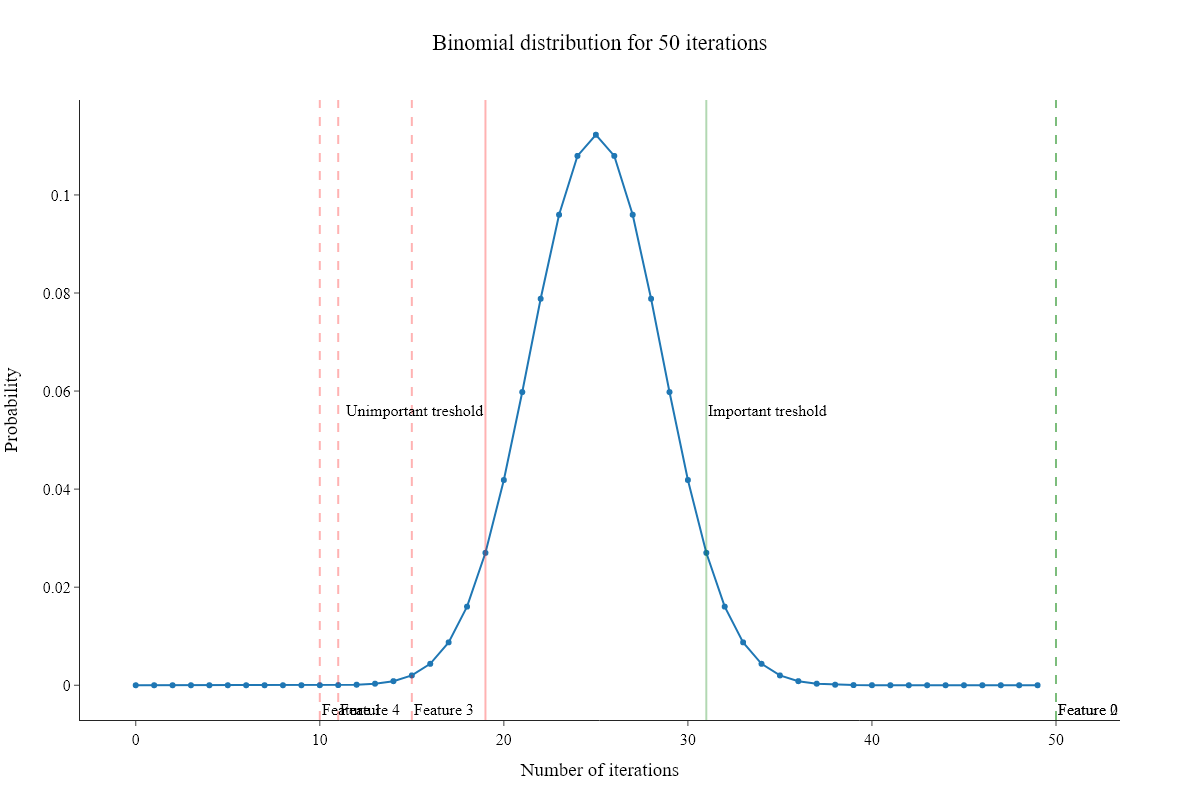

Indices of best features: [0, 2]
Support: [ True False  True False False]


In [26]:
boruta.fit(X, y, verbose=True)
print("Indices of best features: {}".format(boruta.indices_of_best_))
print("Support: {}".format(boruta.support_))

### Zalety

$\text{Metoda użyteczna przede wszystkim do wykrywania zmiennych nieistotnych, ponieważ jeśli jakaś zmienna wielokrotnie miała mniejszą istotność niż sztucznie wygenerowana cech to możemy przypuszczać, że rzeczywiście nie niesie ona informacji.}$

### Wady

$\text{W przypadku dużego zbioru danych metoda jest czasochłonna (po pierwsze: duża liczba iteracji=dużo trenowań modelu, po drugie: duplikacja zmiennych=dwa razy większa macierz).}$

# Porównanie

$\text{W celu porównania algorytmów wykorzystamy sztucznie wygenerowane zbiory danych.}$<p>
$\text{Poniżej zapisano kilka charakterystyk zbiorów:}$<p>
$\text{1. Dwa zbiory danych: jeden z problemem regresji, drugi z problemem klasyfikacji.}$<p>
$\text{2. Każdy zbiór zawiera 10000 obserwacji i 50 zmiennych niezależnych.}$<p>
$\text{3. Wśród zmiennych objaśniających znajdować się będą zmienne istotne (20), nieistotne (30).}$

$\text{Porównywane algorytmy selekcji:}$<p>
$\text{1. Forward Feature Selection.}$<p>
$\text{2. Backward Feature Selection.}$<p>
$\text{3. Recursive Feature Elimination Cross Validation (na podstawie feature\_importance).}$<p>
$\text{4. Recursive Feature Elimination Cross Validation (na podstawie Mutual Information).}$<p>
$\text{5. Boruta.}$

$\text{Do modelowania wykorzystamy drzewo decyzyjne.}$<p>
$\text{Ewaluacja:}$<p>
$\text{1. Czas trenowania.}$<p>
$\text{2. Wyniki walidacji krzyżowej.}$<p>
$\text{3. Wyniki na zbiorze testowym.}$<p>
$\text{4. Skuteczność wyboru zmiennych istotnych.}$<p>
$\text{Dla problemu klasyfikacji metryką do ewaluacji będzie ROC AUC, natomiast dla problemu regresji MSE.}$

## Klasyfikacja

In [27]:
n_informative = 20
X_classification, y_classification = make_classification(n_samples=10000, n_features=50, n_informative=n_informative, n_redundant=0, n_repeated=0, n_clusters_per_class=2, shuffle=False, random_state=17)
X_train_classification, X_test_classification, y_train_classification, y_test_classification = train_test_split(X_classification, y_classification, test_size=0.2, random_state=17)

In [28]:
class Pipeline:
    """This class is a pipeline for feature selection methods. It allows to perform feature selection and evaluation of the model."""

    def __init__(
        self,
        algorithm: typing.Any,
        metric: str,
        cv: typing.Any = KFold(n_splits=5, shuffle=True),
    ):
        """This method initializes the class.

        Args:
            algorithm (typing.Any): algorithm that will be used for feature selection.
            metric (str): metric that will be used for evaluation.
            cv (typing.Any): cross-validation strategy that will be used for evaluation.
        """
        self.algorithm = algorithm
        metrics = {
            "accuracy": [lambda y, y_pred: accuracy_score(y, y_pred), "preds"],
            "roc_auc": [lambda y, y_pred: roc_auc_score(y, y_pred), "probs"],
            "neg_mse": [lambda y, y_pred: -mean_squared_error(y, y_pred), "preds"],
            "neg_rmse": [
                lambda y, y_pred: -mean_squared_error(y, y_pred) ** 0.5,
                "preds",
            ],
            "neg_mae": [lambda y, y_pred: -mean_absolute_error(y, y_pred), "preds"],
        }
        if metric not in metrics:
            raise ValueError("Unsupported metric: {}".format(metric))
        self.metric = metric
        self.eval_metric = metrics[metric][0]
        self.metric_type = metrics[metric][1]
        self.cv = cv

    def fit(
        self,
        X: typing.Union[pd.DataFrame, pd.Series, np.ndarray],
        y: typing.Union[pd.DataFrame, pd.Series, np.ndarray],
        X_test: typing.Union[pd.DataFrame, pd.Series, np.ndarray],
        y_test: typing.Union[pd.DataFrame, pd.Series, np.ndarray],
        important_features: typing.List[int],
        selector: typing.Any,
    ) -> typing.Tuple[float, float, float, float]:
        """This method fits the model.

        Args:
            X (typing.Union[pd.DataFrame, pd.Series, np.ndarray]): input data.
            y (typing.Union[pd.DataFrame, pd.Series, np.ndarray]): target data.
            X_test (typing.Union[pd.DataFrame, pd.Series, np.ndarray]): input test data.
            y_test (typing.Union[pd.DataFrame, pd.Series, np.ndarray]): target test data.
            important_features (typing.List[int]): list of important features (ground truth).
            selector (str): method that will be used for feature selection.

        Returns:
            typing.Tuple[float, float, float, float]: tuple of fit time, test scores, cv scores and features accuracy.
        """
        start = timer()
        selector.fit(X, y)
        end = timer()
        fit_time = end - start
        support = selector.support_
        indices_of_best_ = [i for i in range(len(support)) if support[i] == True]
        features_accuracy = self.calculate_accuracy_of_features(
            X, important_features, indices_of_best_
        )
        X_train_subset = X[:, indices_of_best_]
        X_test_subset = X_test[:, indices_of_best_]
        test_scores = self.evaluate(X_train_subset, y, X_test_subset, y_test)
        cv_scores = self.perform_cv(X_train_subset, y)
        return fit_time, test_scores, cv_scores, features_accuracy

    def calculate_accuracy_of_features(
        self,
        X: np.ndarray,
        important_features: typing.List[int],
        indices_of_best_: typing.List[int],
    ) -> float:
        """This method calculates the accuracy based on important features and those that were selected by selector.

        Args:
            X (np.ndarray): input data.
            important_features (typing.List[int]): list of important features (ground truth).
            indices_of_best_ (typing.List[int]): list of best indices.

        Returns:
            float: accuracy of selection.
        """
        TP = len(set(important_features).intersection(set(indices_of_best_)))
        FP = len(set(indices_of_best_).difference(set(important_features)))
        FN = len(set(important_features).difference(set(indices_of_best_)))
        TN = len(set(range(0, X.shape[1])).difference(set(indices_of_best_)))
        return (TP + TN) / (TP + TN + FP + FN)

    def evaluate(
        self,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray,
    ) -> float:
        """This method evaluates the model.

        Args:
            X_train (np.ndarray): input train data.
            y_train (np.ndarray): target train data.
            X_test (np.ndarray): input test data.
            y_test (np.ndarray): target test data.

        Returns:
            float: evaluation score.
        """
        self.algorithm.fit(X_train, y_train)
        if self.metric_type == "preds":
            y_pred = self.algorithm.predict(X_test)
        else:
            y_pred = self.algorithm.predict_proba(X_test)[:, 1]
        score = self.eval_metric(y_test, y_pred)
        return score

    def perform_cv(self, X: np.ndarray, y: np.ndarray) -> float:
        """This method performs cross-validation.

        Args:
            X: (np.ndarray): input data.
            y: (np.ndarray): target data.

        Returns:
            float: cross-validation score.
        """
        scores = []
        for train_index, test_index in self.cv.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            self.algorithm.fit(X_train, y_train)
            if self.metric_type == "preds":
                y_pred = self.algorithm.predict(X_test)
            else:
                y_pred = self.algorithm.predict_proba(X_test)[:, 1]
            scores.append(self.eval_metric(y_test, y_pred))
        return np.mean(scores)

In [29]:
classification_algorithm = DecisionTreeClassifier(random_state=17)
metric = "roc_auc"
cv = KFold(n_splits=5, shuffle=True)
pipeline = Pipeline(algorithm=classification_algorithm, metric=metric, cv=cv)
important_features = [i for i in range(n_informative)]
selectors = [ForwardFeatureSelection(algorithm=classification_algorithm, metric=metric, cv=cv), BackwardFeatureSelection(algorithm=classification_algorithm, metric=metric, cv=cv), RFECV(estimator=classification_algorithm, step=1, cv=cv, scoring=metric), RFECVMutualInformation(algorithm=classification_algorithm, metric=metric, discrete_features=False, target_discrete=True, cv=cv), Boruta(algorithm=classification_algorithm, max_iter=100)]
dictionary = {"Forward": [], "Backward": [], "RFECV": [], "RFECVMutualInformation": [], "Boruta": []}
for idx, selector in enumerate(selectors):
    fit_time, test_scores, cv_scores, features_accuracy = pipeline.fit(X=X_train_classification, y=y_train_classification, X_test=X_test_classification, y_test=y_test_classification, selector=selector, important_features=important_features)
    dictionary[list(dictionary.keys())[idx]] = [fit_time, test_scores, cv_scores, features_accuracy]

In [30]:
classification_algorithm.fit(X_train_classification, y_train_classification)
y_prob = classification_algorithm.predict_proba(X_test_classification)[:, 1]
baseline_score = roc_auc_score(y_test_classification, y_prob)
print(f"Baseline score (model with all features): {baseline_score}")

Baseline score (model with all features): 0.8289292894520106


In [31]:
df = pd.DataFrame(dictionary).T
df.columns = ["Fit time", "Test scores", "CV scores", "Features accuracy"]
df.style.background_gradient(cmap='Blues')

,Fit time,Test scores,CV scores,Features accuracy
Forward,25.082092,0.851378,0.839872,0.960000
Backward,837.565345,0.833527,0.831508,0.615385
RFECV,31.102418,0.850053,0.850875,1.000000
RFECVMutualInformation,25.956639,0.856003,0.837387,0.870370
Boruta,59.106898,0.850053,0.850298,1.000000


## Regresja

In [32]:
n_informative = 20
X_regression, y_regression = make_regression(n_samples=10000, n_features=50, n_informative=n_informative, shuffle=False, random_state=17)
X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(X_regression, y_regression, test_size=0.2, random_state=17)

In [33]:
regression_algorithm = DecisionTreeRegressor(random_state=17)
metric = "neg_mse"
cv = KFold(n_splits=5, shuffle=True)
pipeline = Pipeline(algorithm=regression_algorithm, metric=metric, cv=cv)
important_features = [i for i in range(n_informative)]
selectors = [ForwardFeatureSelection(algorithm=regression_algorithm, metric=metric, cv=cv), BackwardFeatureSelection(algorithm=regression_algorithm, metric=metric, cv=cv), RFECV(estimator=regression_algorithm, step=1, cv=cv, scoring="neg_mean_squared_error"), RFECVMutualInformation(algorithm=regression_algorithm, metric=metric, discrete_features=False, target_discrete=False, cv=cv), Boruta(algorithm=regression_algorithm, max_iter=100)]
dictionary = {"Forward": [], "Backward": [], "RFECV": [], "RFECVMutualInformation": [], "Boruta": []}
for idx, selector in enumerate(selectors):
    fit_time, test_scores, cv_scores, features_accuracy = pipeline.fit(X=X_train_regression, y=y_train_regression, X_test=X_test_regression, y_test=y_test_regression, selector=selector, important_features=important_features)
    dictionary[list(dictionary.keys())[idx]] = [fit_time, test_scores, cv_scores, features_accuracy]

In [34]:
regression_algorithm.fit(X_train_regression, y_train_regression)
y_pred = regression_algorithm.predict(X_test_regression)
baseline_score = mean_squared_error(y_test_regression, y_pred)
print(f"Baseline score (model with all features): {baseline_score}")

Baseline score (model with all features): 44162.45886375197


In [35]:
df = pd.DataFrame(dictionary).T
df.columns = ["Fit time", "Test scores", "CV scores", "Features accuracy"]
df.style.background_gradient(cmap='Blues')

,Fit time,Test scores,CV scores,Features accuracy
Forward,24.819163,-37582.849520,-38346.488468,0.942308
Backward,746.268521,-40652.621325,-41974.326013,0.566038
RFECV,28.317498,-34518.487269,-35948.314022,0.877193
RFECVMutualInformation,23.804396,-35965.162532,-36884.114201,0.847458
Boruta,44.636988,-34123.183728,-37285.279466,0.892857


Linki:

- https://medium.com/analytics-vidhya/feature-selection-extended-overview-b58f1d524c1c

- https://medium.com/@dancerworld60/exploring-wrapper-methods-for-optimal-feature-selection-in-machine-learning-517ad48c4ac6#:~:text=In%20feature%20selection%2C%20the%20wrapper,to%20evaluate%20subsets%20of%20features.

- https://towardsdatascience.com/getting-data-ready-for-modelling-feature-engineering-feature-selection-dimension-reduction-39dfa267b95a

- https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection